The value of simulations

The value of simulations is highighted by Dr. McElreath throughout his textbook and by [van de Schoot and colleagues](nature.com/articles/s43586-020-00001-2.pdf). I didn't entirely appreciate its value until I implemented this myself. I started by reviewing some materials, then I went down a rabbit hole, where one question naturally branched into other questions. I'll talk about simulations in multiple posts.

We'll start simple, with a weighted coin example. Then we'll move into simple linear regression, then multiple linear regression and thinking from a causal perspective. As most of my recent posts have been inspired by my learning of Bayesian inference, much credit goes to Dr. McElreath's Statistical Rethinking, its associated [`pymc` repo](https://github.com/pymc-devs/resources/tree/master/Rethinking_2). Colleagues at UCSF who are experts in simulations and causal models have also been a great source.

Let's get started!

Dr. McElreath highlights how much can be done without data.

- have arrows pointing in different directions (X > Y > Z; X > Y < Z)
- have outcomes vary, in each condition (predict Y, predict Z, etc.)
- show how all can be correlated
- impact of sample size
- simulating multi-level models


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import daft
from causalgraphicalmodels import CausalGraphicalModel

sns.set_context("talk")

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz


def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Running models forwards and backwards

We can input parameters to generate data. Or we can start from data, come up with a model to infer a parameter. When most people do statistics, they're doing the latter. But running a model in both directions can help us understand things more deeply.

**insert graphic**

# Binomial example

Let's pretend we have a weighted coin. In many problems, we're asked to deduce the true proportion that the coin comes up heads (or tails). This would be **parameter estimation**. A parameter is typically *unobserved* in contrast to data (the number of heads for example). But for simulation, we *input a known parameter* (how weighted the coin is) and generate data. In our simulation, let's say that the true proportion the coin comes up heads is 0.7. Since each coin toss is independent of the other, these are conditions for a binomial distribution. We'll illustrate simulations with two packages.

- using [`scipy.stats`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)
- using `pymc` module

## Simulation with `scipy.stats`

Let's imagine we do two coin flips. The possibilities after three tosses ($n$=2) is to observe 0 heads (H), 1 H, or 2 H. The number of observed heads is assigned $k$. We can get the probability mass function like this.

In [4]:
# k = 0, 1, or 2 heads
stats.binom.pmf(k=range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

<IPython.core.display.Javascript object>

This means that, after two coin flips, we expect to observe 0 heads  with 9% probability, 1 head with 42% probability, and 2 heads with 49% probability. These three possibilities sum to 100%. We can't get more hits on water ($k$) than the number of tosses ($n$). This is made clear if we try to input a value of $k$ that is $n$. (We'll do an explicit construction of a list of k values.)

In [6]:
stats.binom.pmf(k=[0, 1, 2, 3], n=2, p=0.7)

array([0.09, 0.42, 0.49, 0.  ])

<IPython.core.display.Javascript object>

We don't get an error, we simply get a probability of zero when $k > n$. Now let's simulate.

We can use `stats.binom.rvs` to input parameters and generate samples. Let's do multiple trials, which is parameterized by `size`. To be clear, each trial means we're doing two tosses and recording the number of heads in that trial. We'll repeat this until we have 10 total trials.

In [7]:
# Use rvs to make dummy observations
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 2, 1, 1, 1, 2, 2, 2, 2, 1])

<IPython.core.display.Javascript object>

If you keep executing this cell, you'll get a new set of values for observed W. We can also generate a high number of trials by simply making `size` large. We'll do 10,000 trials.

In [47]:
dummy_h = stats.binom.rvs(n=2, p=0.7, size=10 ** 5)
dummy_h

array([2, 1, 2, ..., 1, 2, 2])

<IPython.core.display.Javascript object>

And from here, we can see how well the proportion of samples for each water value generated by the simulation matches the proportions determined analytically (using `stats.binom.pmf`).

In [9]:
# Wrap the list in a series so I can use `value_counts`
pd.Series(dummy_w).value_counts() / 10 ** 5

2    0.48837
1    0.42089
0    0.09074
dtype: float64

<IPython.core.display.Javascript object>

The numbers are pretty close.

## Inference: estimating the parameter from observed data

Now let's run the model backwards with `pymc`, using the data we have generated as our likelihood. This might seem like a silly exercise since the purpose of inference is to estimate an unknown parameter. But the point of this exercise is to see how the two directions of model running are connected.

Here is our model equation. We can read this as "the number of heads we will observe is binomially distributed after two tosses and some unknown parameter p." We have to give $p$ some plausible prior distribution. Since $p$ should be between 0 and 1, a beta distribution is a good choice. I wrote about the beta distribution in a prior post [here](https://benslack19.github.io/data%20science/statistics/prior-and-beta/).

$$ H \sim \text{Binomial}(n=2, p) $$
$$ p \sim \text{Beta}(\alpha=2, \beta=2) $$

I choice beta to be parameterized as (2,2) since it is fairly conservative, with most of the mass suggesting it is a fair coin. You'll see the shape of this below, when we put it with the posterior. We can get the posterior in the following code. **There is a closed form solution where we can get the posterior analytically. The following is a way to get it with MCMC. While using MCMC is overkill for this problem, it is applicable with more complicated models.**

In [10]:
# Generate observed data
dummy_h = stats.binom.rvs(n=2, p=0.7, size=10)

# Infer the parameter
with pm.Model() as m1:

    # prior
    p = pm.Beta("p", alpha=2, beta=2)

    # likelihood with unknown parameter p, observed dummy_w
    H = pm.Binomial("W", n=2, p=p, observed=dummy_w)

    # posterior
    trace_m1 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=False
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

Let's plot the prior and posterior for $p$ together.

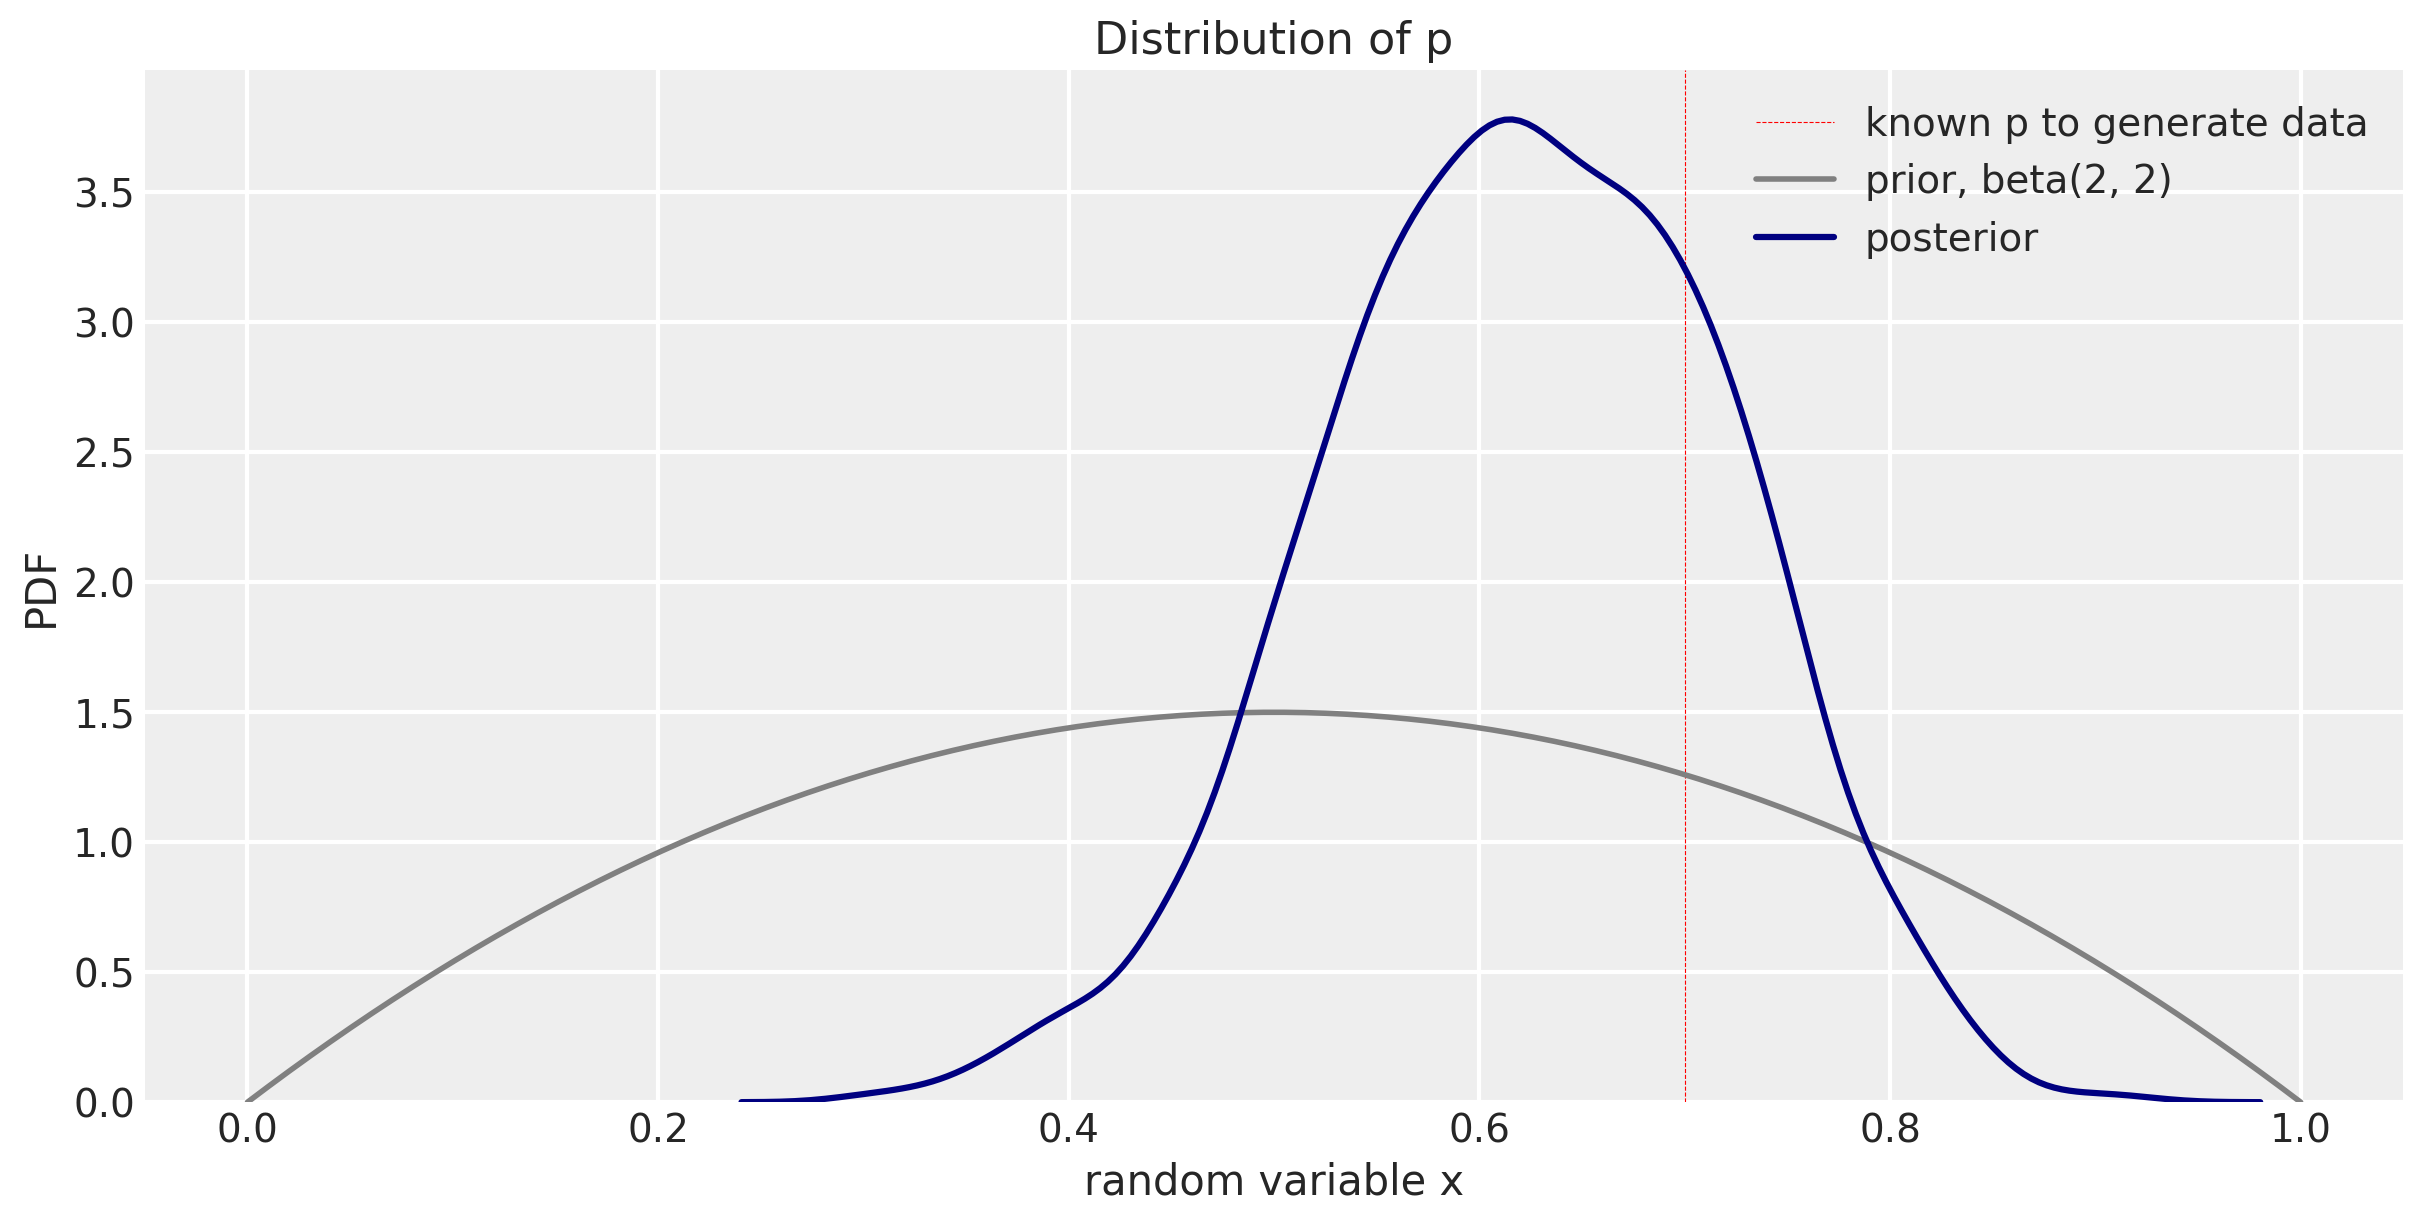

<IPython.core.display.Javascript object>

In [30]:
a = 2
b = 2

f, ax1 = plt.subplots(figsize=(12, 6))

# known parameter to generate data
ax1.axvline(
    0.7, lw=0.4, color="red", linestyle="dashed", label="known p to generate data"
)

# prior
x = np.linspace(stats.beta.ppf(0.00, a, b), stats.beta.ppf(1.00, a, b), 100)
prior_label = "prior, beta(" + str(a) + ", " + str(b) + ")"
ax1.plot(x, stats.beta.pdf(x, a, b), lw=2, color="gray", label=prior_label)

# Make the posterior values accessible and plot
df_trace_m1 = trace_m1.to_dataframe()
sns.kdeplot(df_trace_m1[("posterior", "p")], ax=ax1, color="navy", label="posterior")

ax1.set_title("Distribution of p")
ax1.set_xlabel("random variable x")
ax1.set_ylabel("PDF")
ax1.legend()

You can see how our distribution of $p$ narrows and moves toward the known true value of 0.7. Note that it hasn't centered over 0.7 yet. This will happen with more trials. But we can see that the 89% compatibility interval contains 0.7.

In [31]:
az.summary(trace_m1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.623,0.097,0.474,0.778,0.002,0.002,1725.0,1714.0,1749.0,2869.0,1.0


<IPython.core.display.Javascript object>

## Simulation and inference with `pymc`

In [44]:
# Generate observed data
dummy_h = stats.binom.rvs(n=2, p=0.7, size=10)

# Infer the parameter
with pm.Model() as m2:

    # prior
    p = pm.Beta("p", alpha=2, beta=2)

    # likelihood with known parameter p, observed dummy_h
    W = pm.Binomial("W", n=2, p=p, observed=dummy_h)

    # simulations with prior
    prior_checks = pm.sample_prior_predictive()

    # posterior
    trace_m2 = pm.sample(
        draws=1000, random_seed=19, return_inferencedata=True, progressbar=False
    )

    # simulations with posterior
    posterior_checks = pm.sample_prior_predictive(samples=10)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


<IPython.core.display.Javascript object>

In [45]:
# put after W
prior_checks

{'p_logodds__': array([-1.41146383e+00,  1.14811883e+00,  1.17109004e+00, -7.50470470e-01,
        -2.97943133e-01,  3.95313337e-01,  1.49738722e+00, -2.84047640e-02,
        -6.19221206e-01,  1.71186300e+00, -1.96109406e+00, -5.89818920e-01,
        -1.19972079e-01, -1.86816206e+00,  1.00058623e+00, -6.52148940e-01,
        -3.77074990e-03, -5.21516643e-01,  1.12762268e+00,  7.08590131e-01,
         1.84672649e-02, -4.09621604e-01,  1.56127021e+00, -3.47294743e-01,
        -7.28150309e-01, -1.45207170e+00, -1.29569093e+00, -4.23464628e-01,
        -1.29676151e+00,  3.37183522e-02,  5.98036770e-01, -3.20819861e-01,
         1.68963431e-01, -1.13508990e+00, -1.07632381e+00,  5.19962931e-02,
         3.00906092e-01,  7.48845363e-01,  1.72484177e+00,  3.12293343e-01,
        -3.56757851e-01,  9.94634409e-02, -3.65368193e-02, -4.85034689e-01,
        -2.40910346e-01, -1.14231057e+00, -1.06117320e+00, -9.91418044e-01,
         2.95911537e+00, -3.56805054e-02, -5.90042695e-01,  9.16812320e-0

<IPython.core.display.Javascript object>

In [46]:
prior_checks["W"].shape

(500, 10)

<IPython.core.display.Javascript object>

In [34]:
posterior_checks

{'p_logodds__': array([-2.80026206,  0.97740945,  1.29524356, -0.63677983, -0.64831409,
         1.61117527, -1.00503202, -0.43121748,  2.55768266,  0.47951135]),
 'W': array([[0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [2, 2, 1, 1, 1, 1, 1, 1, 1, 2],
        [2, 2, 2, 1, 1, 2, 2, 2, 2, 2],
        [1, 1, 1, 1, 2, 0, 0, 0, 0, 1],
        [0, 2, 0, 0, 0, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 1, 2, 2, 2],
        [1, 0, 1, 1, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 2],
        [2, 2, 1, 2, 2, 2, 2, 2, 2, 1],
        [2, 2, 1, 1, 1, 0, 1, 1, 2, 2]]),
 'p': array([0.05731002, 0.72659389, 0.78503339, 0.34597483, 0.34336955,
        0.83357449, 0.26795322, 0.39383565, 0.92808795, 0.61763248])}

<IPython.core.display.Javascript object>

In [40]:
pd.Series(prior_checks["W"][:, 0]).value_counts() / 10

1    0.4
2    0.4
0    0.2
dtype: float64

<IPython.core.display.Javascript object>

## Simulation with `pymc`

The package `pymc` has its own prior (and posterior) simulations. We normally use this construction to specify a model with a prior and likelihood, but we can simply put in known parameter.

$$ W \sim \text{Binomial}(n,p) $$
$$ n = 2 $$
$$ p = 0.7 $$

In [5]:
df_tosses = pd.DataFrame({"toss": range(3), "result": [0, 1, 1]})
df_tosses

,toss,result
0,0,0
1,1,1
2,2,1


<IPython.core.display.Javascript object>

In [52]:
# For simulation
with pm.Model() as m1:

    # likelihood with known parameters
    H = pm.Binomial("H", n=2, p=0.7)
    # sample
    prior_checks = pm.sample_prior_predictive(samples=10)

<IPython.core.display.Javascript object>

In [53]:
prior_checks

{'H': array([1, 2, 2, 1, 2, 1, 2, 1, 2, 0])}

<IPython.core.display.Javascript object>

In [48]:
# For simulation
with pm.Model() as m1:
    
    # likelihood with known parameters
    W = pm.Binomial("W", n=2, p=0.7)
    # sample
    prior_checks = pm.sample_prior_predictive(samples=10)
    
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [W]
INFO:pymc3:Metropolis: [W]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [33]:
az.summary(trace_m1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
W,1.395,0.66,1.0,2.0,0.024,0.017,742.0,742.0,738.0,897.0,1.01


<IPython.core.display.Javascript object>

In [ ]:
with pm.Model() as m1:
    # prior
    p = pm.Beta("p", alpha=2, beta=2)

    w = stats.binom.rvs(n=2, p=0.7, size=10**5)

    # likelihood, input the generated data as observed
    W = pm.Binomial("W", n=n, p=p, observed=prior_checks["W"])

    # sample
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)


In [175]:
# For inference

p = []

with pm.Model() as m1:
    
    # prior
    p1 = pm.Beta("p", alpha=2, beta=2)

    # likelihood, input the generated data as observed
    W = pm.Binomial("W", n=2, p=p, observed=prior_checks["W"])

    # sample
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [176]:
az.summary(trace_m1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.685,0.057,0.595,0.774,0.001,0.001,1651.0,1651.0,1673.0,2835.0,1.0


<IPython.core.display.Javascript object>

In [18]:
prior_checks["W"]

array([2, 1, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 1, 2,
       0, 1, 2, 1, 0, 1, 2, 2])

<IPython.core.display.Javascript object>

In [10]:
# For sample size test

est_p = dict()

for sample_size in [2, 5, 10, 25, 50]:

    with pm.Model() as m1:

        # prior
        p = pm.Beta("p", alpha=2, beta=2)
        
        w = stats.binom.rvs(n=2, p=0.7, size=10**5)
        

        # likelihood, input the generated data as observed
        W = pm.Binomial("W", n=n, p=p, observed=prior_checks["W"])

        # sample
        trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

    est_p[n] = az.summary(trace_m1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The acceptance probability does not match the target. It is 0.8792634270356184, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8878256109794483, but should be close to 0.8. Try to increase the number of tuning steps.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

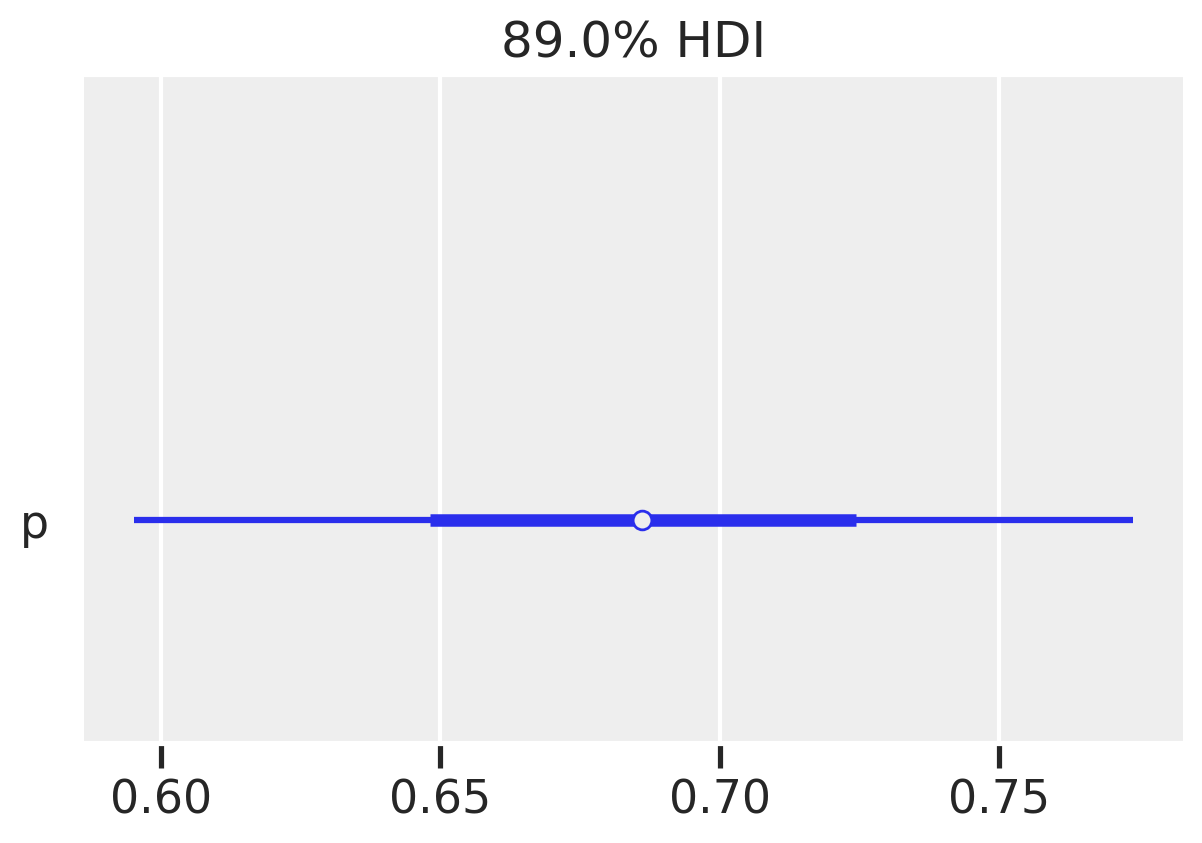

<IPython.core.display.Javascript object>

In [178]:
az.plot_forest(trace_m1, combined=True)

Give $n$ a distribution. Want something bounded by zero or positive. Gamma distribution will work.

In [204]:
stats.gamma.rvs(2, size=100).mean()

1.84225689439146

<IPython.core.display.Javascript object>

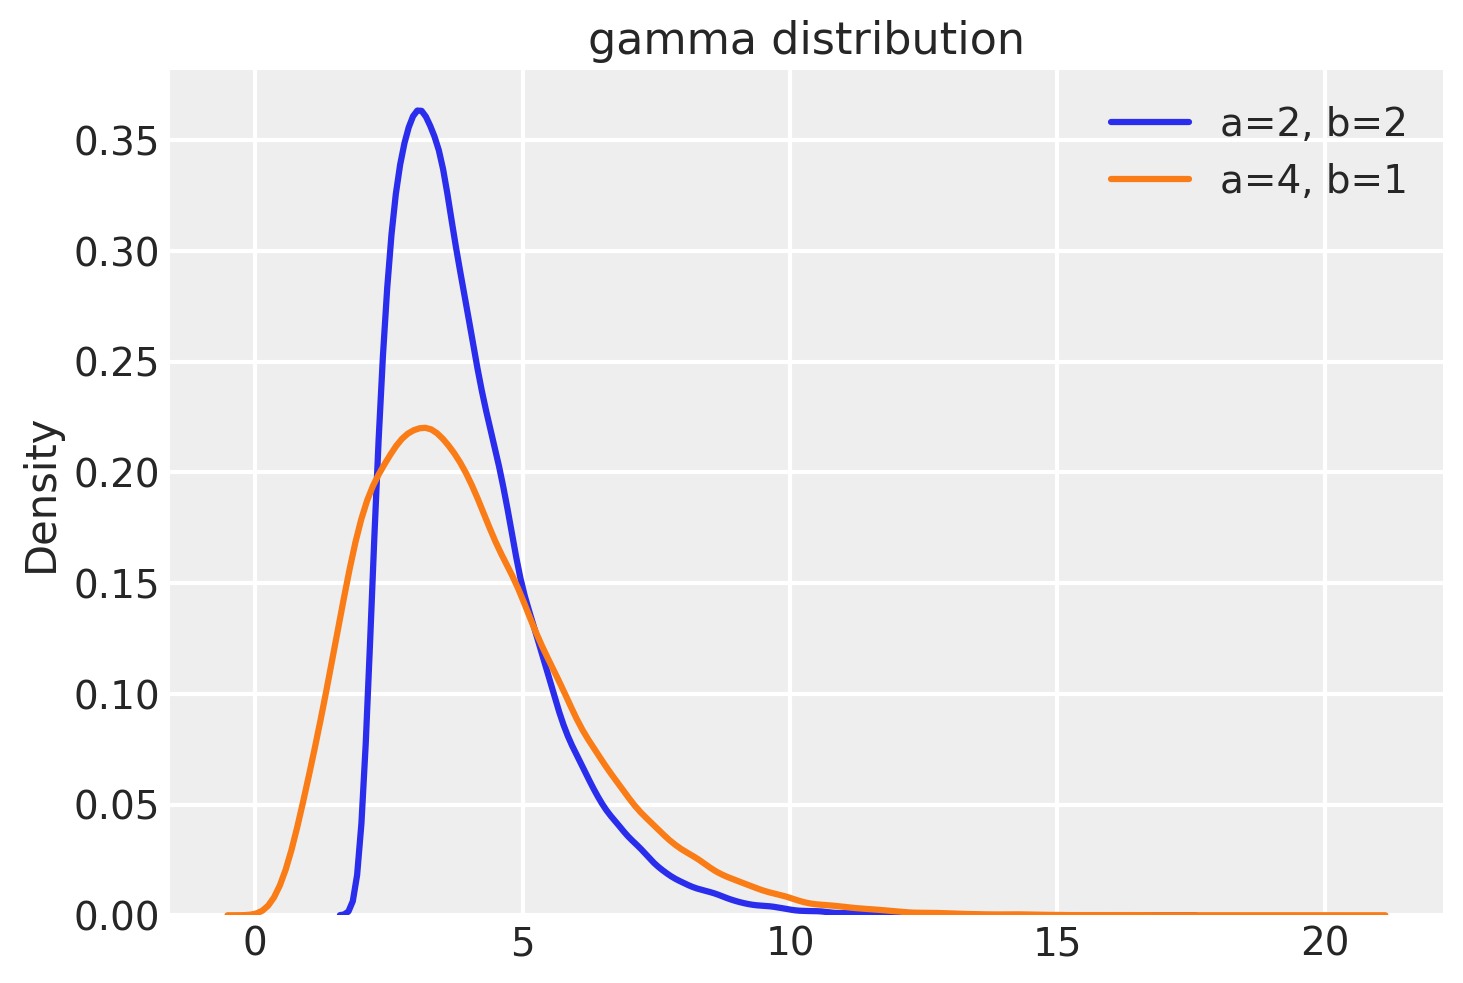

<IPython.core.display.Javascript object>

In [156]:
f, ax1 = plt.subplots()
sns.kdeplot(stats.gamma.rvs(2, 2, size=10**5), ax=ax1, label='a=2, b=2')
sns.kdeplot(stats.gamma.rvs(4, size=10**5), ax=ax1, label='a=4, b=1')    # default scale is 1 (1/b)
ax1.set_title('gamma distribution')
ax1.legend()

In [71]:
np.exp(-100)

3.720075976020836e-44

<IPython.core.display.Javascript object>

In [195]:
with pm.Model() as m2:

    # prior
    # n = pm.Gamma("n", alpha=2, beta=2)
    p = pm.Beta("p", alpha=2, beta=2)

    # likelihood
    W = pm.Binomial("W", n=2, p=p)

    # sample
    trace_m2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)
    prior_checks = pm.sample_prior_predictive(samples=10**5)

prior_checks['W'][0:10]
pd.Series(prior_checks['W']).value_counts() / 10**5

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>NUTS: [p]
INFO:pymc3:>NUTS: [p]
>Metropolis: [W]
INFO:pymc3:>Metropolis: [W]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


1    0.40024
0    0.30035
2    0.29941
dtype: float64

<IPython.core.display.Javascript object>

# Running forwards and backwards, impact of sample size (number of trials)

In [52]:
# For sample size test

est_p = dict()

for sample_size in [2, 5, 10, 25, 50]:
    
    # simulate observed data (count the number of heads)
    dummy_w = stats.binom.rvs(n=2, p=0.7, size=sample_size)
    
    # run inference (deduce the parameter)
    with pm.Model() as m1:

        # prior
        p = pm.Beta("p", alpha=2, beta=2)

        # likelihood with unknown parameter p, oberved dummy_w
        W = pm.Binomial("W", n=2, p=p, observed=dummy_w)

        trace_mn = pm.sample(
            draws=1000, random_seed=19, return_inferencedata=True, progressbar=False
        )

    est_p[sample_size] = az.summary(trace_mn)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_

<IPython.core.display.Javascript object>

In [54]:
df_n

,sample_size,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,2,0.619,0.163,0.353,0.867,0.004,0.003,1667.0,1585.0,1646.0,2278.0,1.0
1,5,0.712,0.118,0.533,0.901,0.003,0.002,1617.0,1547.0,1577.0,1922.0,1.0
2,10,0.707,0.092,0.560,0.846,0.002,0.002,1478.0,1459.0,1492.0,2479.0,1.0
3,25,0.721,0.061,0.625,0.818,0.001,0.001,1689.0,1665.0,1698.0,2536.0,1.0
4,50,0.749,0.043,0.678,0.814,0.001,0.001,1687.0,1666.0,1668.0,2668.0,1.0


<IPython.core.display.Javascript object>

In [53]:
df_n = pd.concat(est_p).reset_index()
df_n = df_n.rename({"level_0": "sample_size"}, axis=1).drop("level_1", axis=1)

<IPython.core.display.Javascript object>

In [107]:
df_n["hdi_94.5%"] - df_n["mean"]

0    0.248
1    0.189
2    0.139
3    0.097
4    0.065
dtype: float64

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'number of trials'),
 Text(0, 0.5, 'SD of estimate'),
 Text(0.5, 1.0, 'SD with number of trials')]

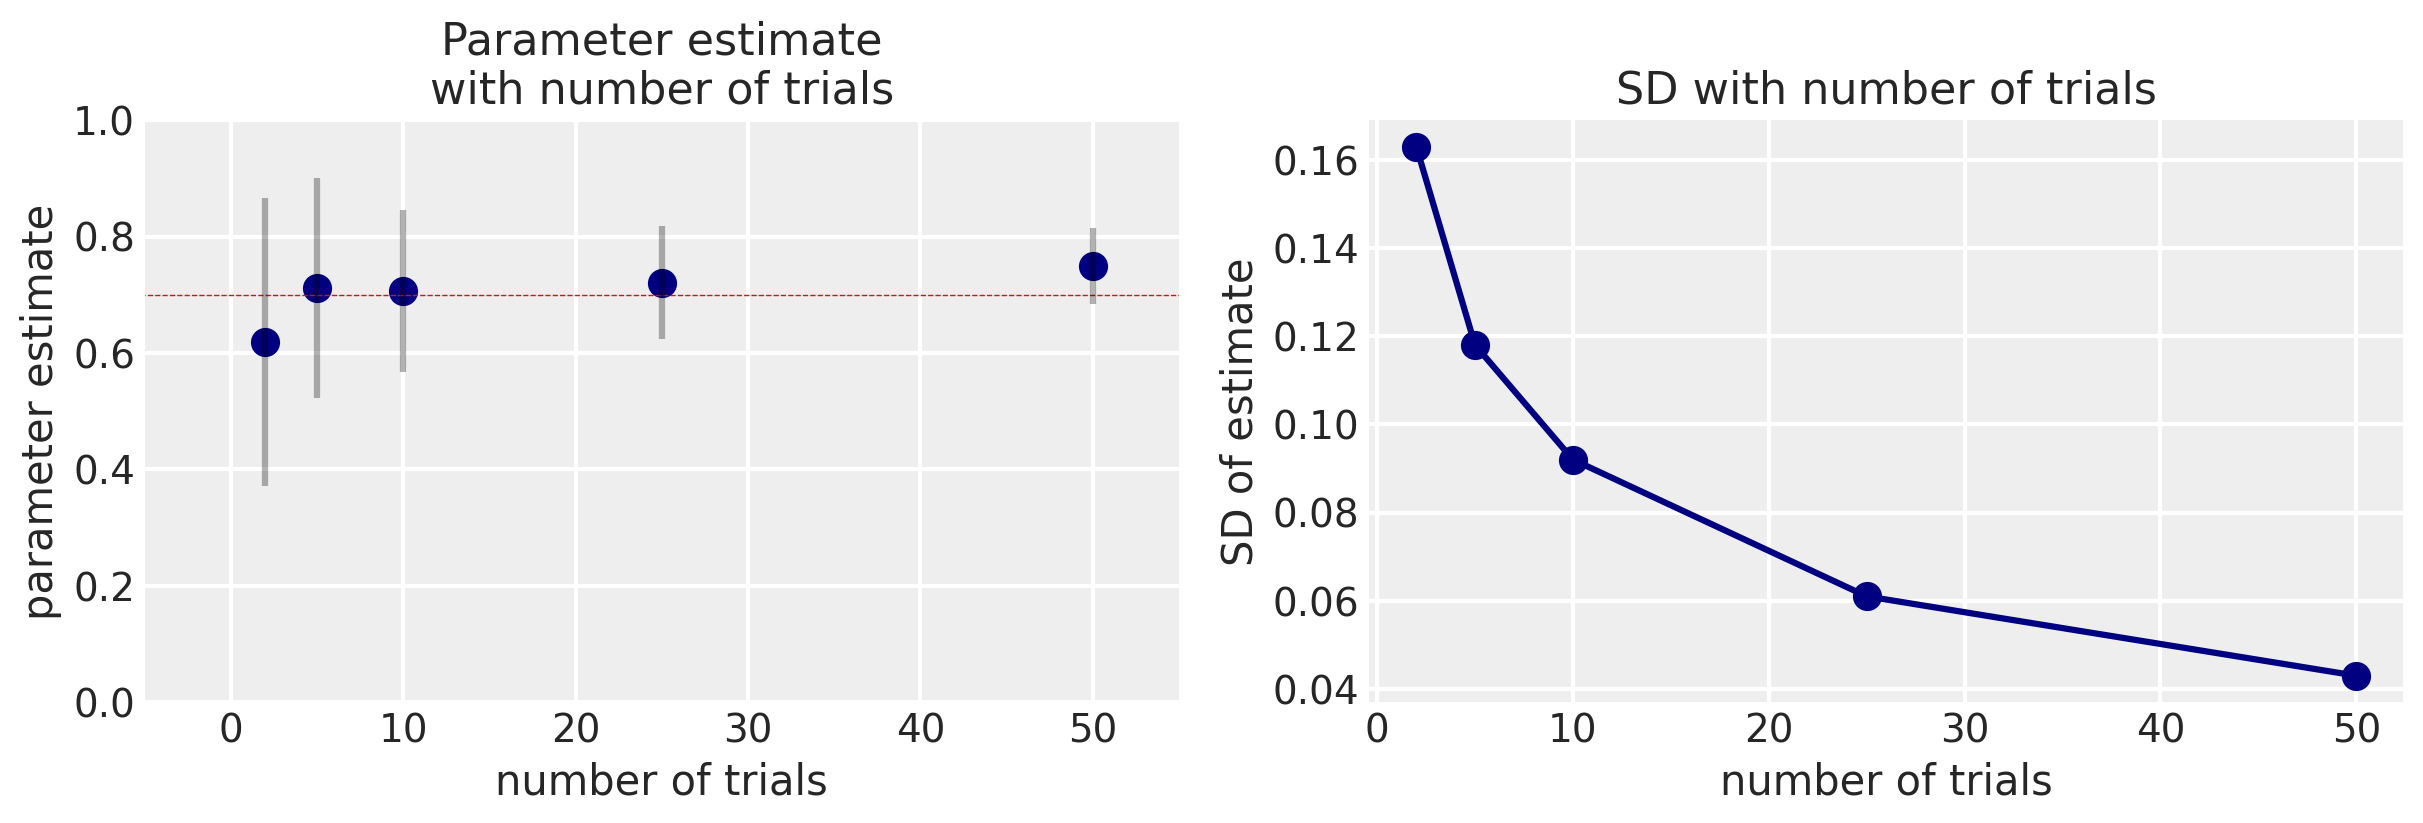

<IPython.core.display.Javascript object>

In [110]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hlines(xmin=-10, xmax=60, y=0.7, linestyle='dashed', color='red', linewidth=0.5)
ax1.errorbar(
    df_n["sample_size"],
    df_n["mean"],
    yerr=df_n["hdi_94.5%"] - df_n["mean"],  # yerr plots symmetrically
    fmt="none",
    c="black",
    alpha=0.3
)
ax1.scatter(df_n["sample_size"], df_n["mean"], color='navy')
ax1.set(xlabel='number of trials',
        ylabel='parameter estimate',
        xlim=[-5, 55],
        ylim=[0, 1],
        title='Parameter estimate\nwith number of trials')

ax2.scatter(df_n["sample_size"], df_n["sd"], color='navy')
ax2.plot(df_n["sample_size"], df_n["sd"], color='navy')
ax2.set(xlabel='number of trials',
        ylabel='SD of estimate',
        title='SD with number of trials')


As we might intuit, we have a clear relationship between the number of trials (the number of rounds we toss the coin twice) and the error we'd get in estimating the parameter. On the left, the dashed red line is the known parameter, points are the parameter estimate for a given number of trials, and the gray lines represent 89% compatibility intervals. On the right, we're plotting the standard deviation (SD) as a function of the number of trials.

# Two uncertain coins

OK, where does this leave us? How can this practically help in our research work? In the real world, we're dealing with a lot of uncertainty, but at least this approach can help us determine if we can at least *answer* our question. Let's stick with the coins paradigm. Imagine that we need a coin that is 0.7 but not 0.6.

## Linear model with DAG

Now let's try to level up and do simulations based on a DAG.

Categorical variables (treatment or not, fungus or not)

h0 --> h1 <-- F <-- T

Let's imagine that final height is our variable of interest.

In [3]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(10, 2, size=N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], N / 2)
fungus = stats.binom.rvs(n=1, p=0.5 - treatment*0.4, size=N)

# generate projected heights
h1 = h0 + stats.norm.rvs(5 - 3 * fungus, size=N) # default scale parameter is 1

<IPython.core.display.Javascript object>

In [4]:
df_sim_plants = pd.DataFrame(
        {"h0":h0,
        "h1":h1,
        "T":treatment,
        "F":fungus}
    )

df_sim_plants.head()

,h0,h1,T,F
0,9.417136,13.263214,0,1
1,7.459338,9.471512,0,1
2,11.839598,17.719684,0,0
3,14.588947,19.582066,0,0
4,9.322042,13.225175,0,0


<IPython.core.display.Javascript object>

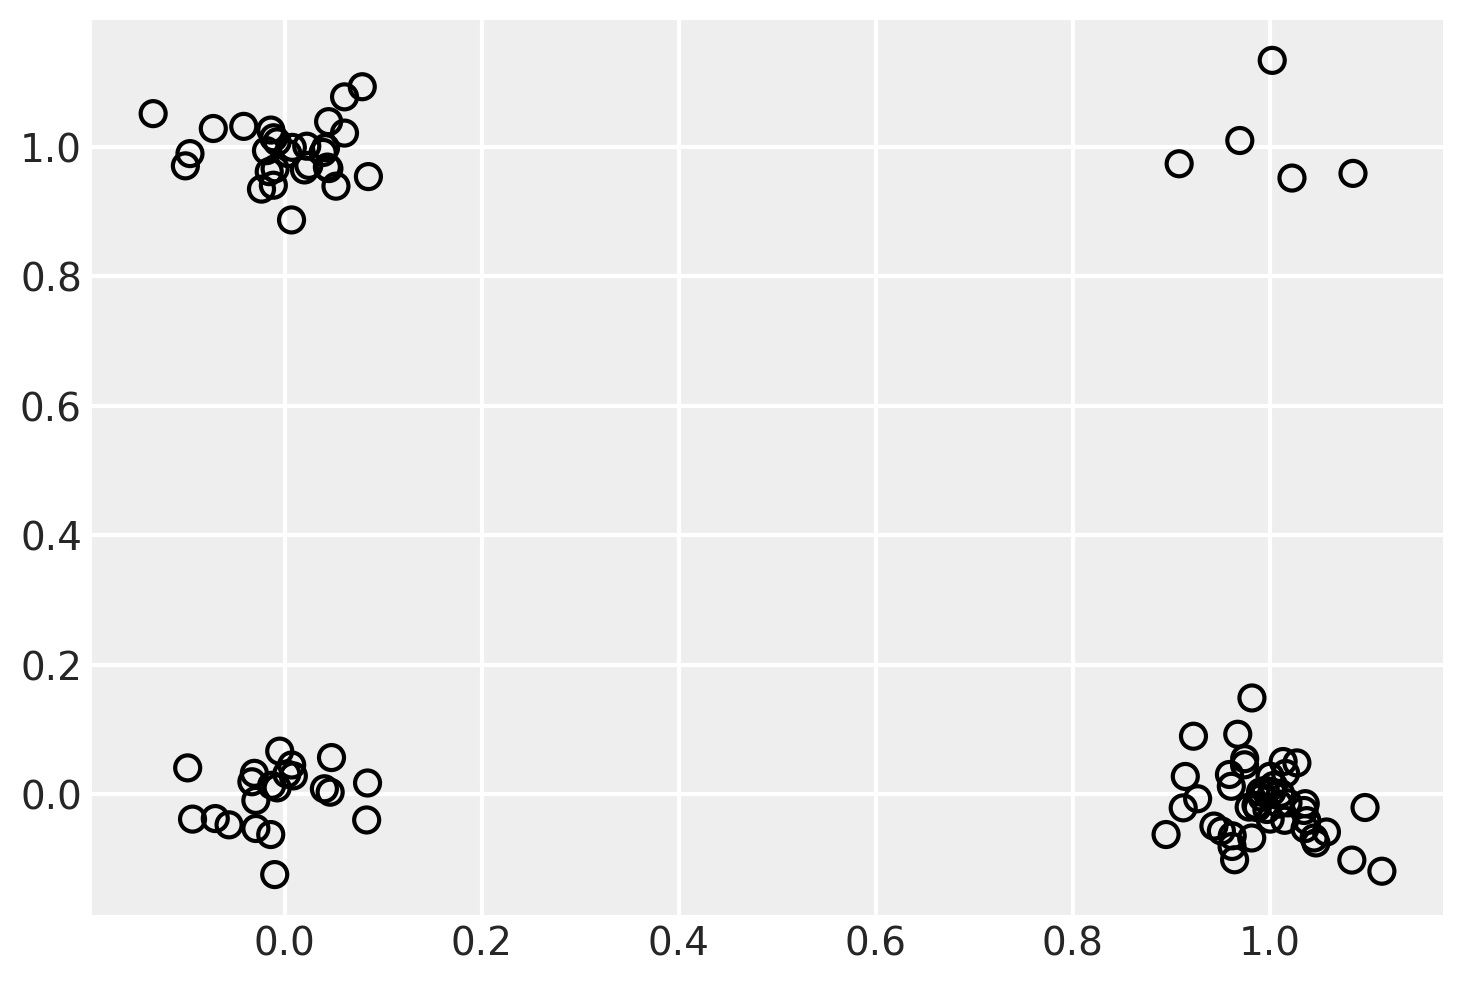

<IPython.core.display.Javascript object>

In [15]:
x_jitter = np.random.normal(0, 0.05, size=len(df_sim_plants))
y_jitter = np.random.normal(0, 0.05, size=len(df_sim_plants))
f, ax1 = plt.subplots()
ax1.scatter(
    df_sim_plants['T'] + x_jitter,
    df_sim_plants['F'] + y_jitter,
    facecolors='none',
    edgecolors='k'
)

In [5]:
az.summary(df_sim_plants.to_dict(orient="list"), kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
h0,9.82,1.89,5.35,11.84
h1,13.81,2.24,9.47,16.63
T,0.50,0.50,0.00,1.00
F,0.34,0.48,0.00,1.00


<IPython.core.display.Javascript object>

Feed data back into a model. First, use proportions because we don't know absolute height.

Will reference variables by dataframe since that's how we'd get our data.

In [6]:
with pm.Model() as m3:
    
    # priors
    p = pm.Lognormal("p", 0, 0.25) 
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = p*df_sim_plants['h0']

    # likelihood
    h1 = pm.Normal("h1", mu, sigma, observed=df_sim_plants['h1'])

    # prior predictive checks
    prior_checks_m3 = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m3 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

We can look at the prior predictive simulation to determine the range of how we expect height to change.

In [7]:
az.summary(prior_checks_m3['p'])

arviz - WARNING - Shape validation failed: input_shape: (1, 100000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,1.033,0.264,0.625,1.425,0.001,0.001,97869.0,97869.0,97828.0,99658.0,NaN


<IPython.core.display.Javascript object>

We can look at the highest probability density interval and say that the height of the plant may shrink to ~60% of its original height or grow to just over 40% of its original height. Remember that this is just based off the priors.

Now let's actually take a look at how the data changes our predictions.

In [256]:
az.summary(trace_m3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,1.421,0.018,1.394,1.449,0.000,0.000,3886.0,3886.0,3895.0,2896.0,1.0
sigma,1.764,0.126,1.570,1.969,0.002,0.001,3712.0,3650.0,3780.0,2534.0,1.0


<IPython.core.display.Javascript object>

Here, we're more confident that the range is around 40% growth. Now let's actually take into account information from the DAG.

In [ ]:
with pm.Model() as m4:
    
    # priors
    p = pm.Lognormal("p", 0, 0.25) 
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = p*df_sim_plants['h0']

    # likelihood
    h1 = pm.Normal("h1", mu, sigma, observed=df_sim_plants['h1'])

    # prior predictive checks
    prior_checks_m4 = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m4 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

In [58]:
prior_checks_m4

NameError: name 'prior_checks_m4' is not defined

<IPython.core.display.Javascript object>

# 15M4

Simulate the following DAG: X -> Y -> Z. 

Now build a model predicting Y using both X and Z. What is the confound that arises?

$$ Y = \beta_1X + \beta_2Z $$

In [10]:
# start with x coming from random draws of a normal distribution around 0
X = stats.norm.rvs(0, 1, size=100)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
# use a known coefficient
Y = bX_sim * stats.norm.rvs(X, 1, size=100)
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z = np.random.normal(Y, 1, size=100)
# Z = np.random.normal(0, 1, size=100)*Y +

df_sim = pd.DataFrame({"X": X, "Y": Y, "Z": Z})

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


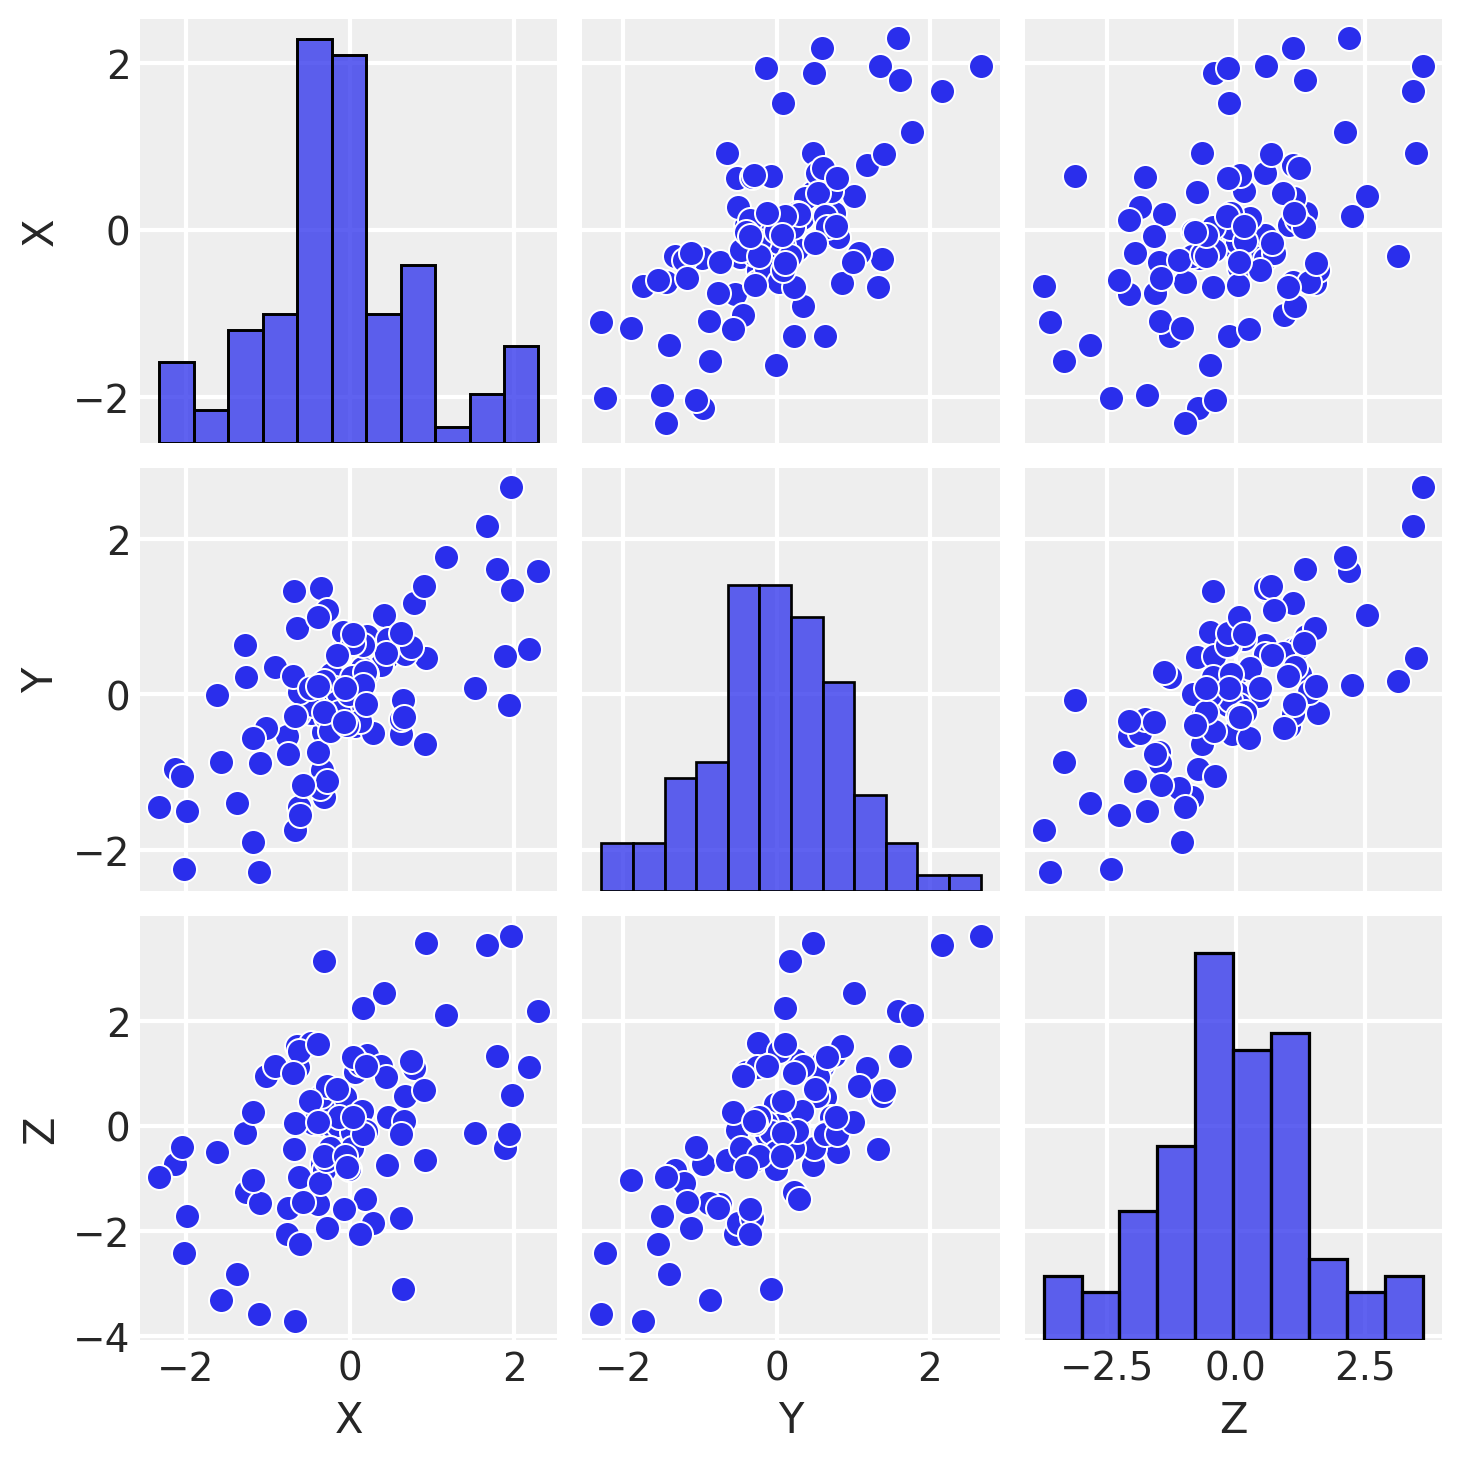

<IPython.core.display.Javascript object>

In [9]:
sns.pairplot(df_sim)

## Using only X as predictor variable

In [17]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = bx * df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [25]:
sm.OLS(df_sim["Y"], df_sim["X"]).fit().params

X    0.693398
dtype: float64

<IPython.core.display.Javascript object>

In [26]:
az.summary(trace_m15m4a)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bx,0.692,0.064,0.592,0.796,0.001,0.001,3569.0,3569.0,3578.0,2653.0,1.0
sigma,0.619,0.045,0.541,0.684,0.001,0.001,3512.0,3471.0,3569.0,2740.0,1.0


<IPython.core.display.Javascript object>

## Using X and Z as predictor variables

In [18]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = bx * df_sim['X'] + bz * df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [27]:
sm.OLS(df_sim["Y"], df_sim[["X", "Z"]]).fit().params

X    0.542048
Z    0.266678
dtype: float64

<IPython.core.display.Javascript object>

In [28]:
az.summary(trace_m15m4b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bx,0.542,0.064,0.439,0.642,0.001,0.001,3413.0,3413.0,3416.0,2685.0,1.0
bz,0.266,0.055,0.177,0.352,0.001,0.001,3106.0,3106.0,3103.0,2794.0,1.0
sigma,0.556,0.040,0.490,0.616,0.001,0.000,4507.0,4481.0,4485.0,2740.0,1.0


<IPython.core.display.Javascript object>

## Plot comparison

Text(0.5, 1.0, 'X (causal) and Z (descendant)')

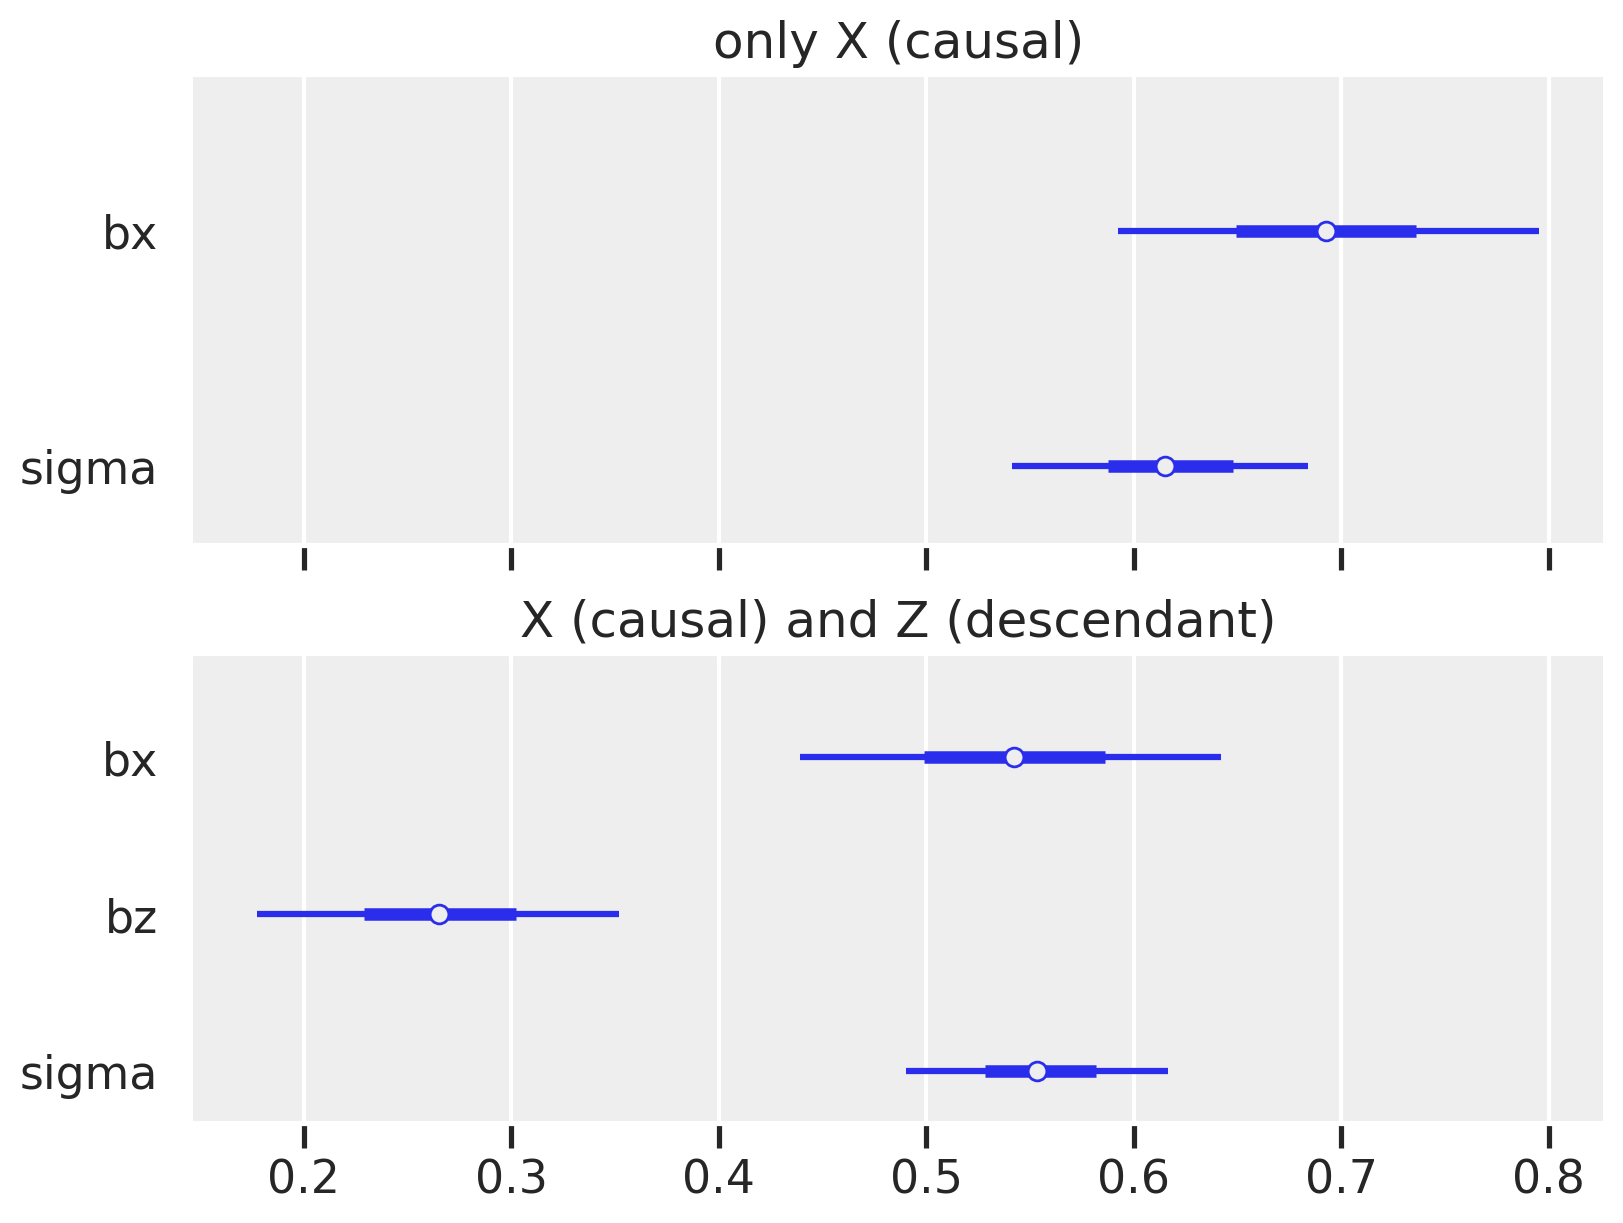

<IPython.core.display.Javascript object>

In [98]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
az.plot_forest(trace_m15m4a, combined=True, ax=ax1)
ax1.set_title("only X (causal)")

az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
ax2.set_title("X (causal) and Z (descendant)")

Marco's tip:
- pretend z is like Y observed
- measurement error ....
- like shrinkage for coefficient



## Random stuff below

### Sample size impact

In [144]:
coef_list = list()
sample_size_list = [10, 100, 200, 500, 1000]
for ss in sample_size_list:
    X1 = stats.norm.rvs(0, 1, size=ss)
    # make y come from random draws of a normal distribution around x
    Y1 = stats.norm.rvs(X1, 1, size=ss)
    coef, se = sm.OLS(Y1, X1).fit().params, sm.OLS(Y1, X1).fit().bse
    coef_list.append((coef[0], se[0]))


<IPython.core.display.Javascript object>

array([0.41306031, 0.10459929, 0.07013674, 0.0455392 , 0.032457  ])

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'sample size'), Text(0, 0.5, 'standard error')]

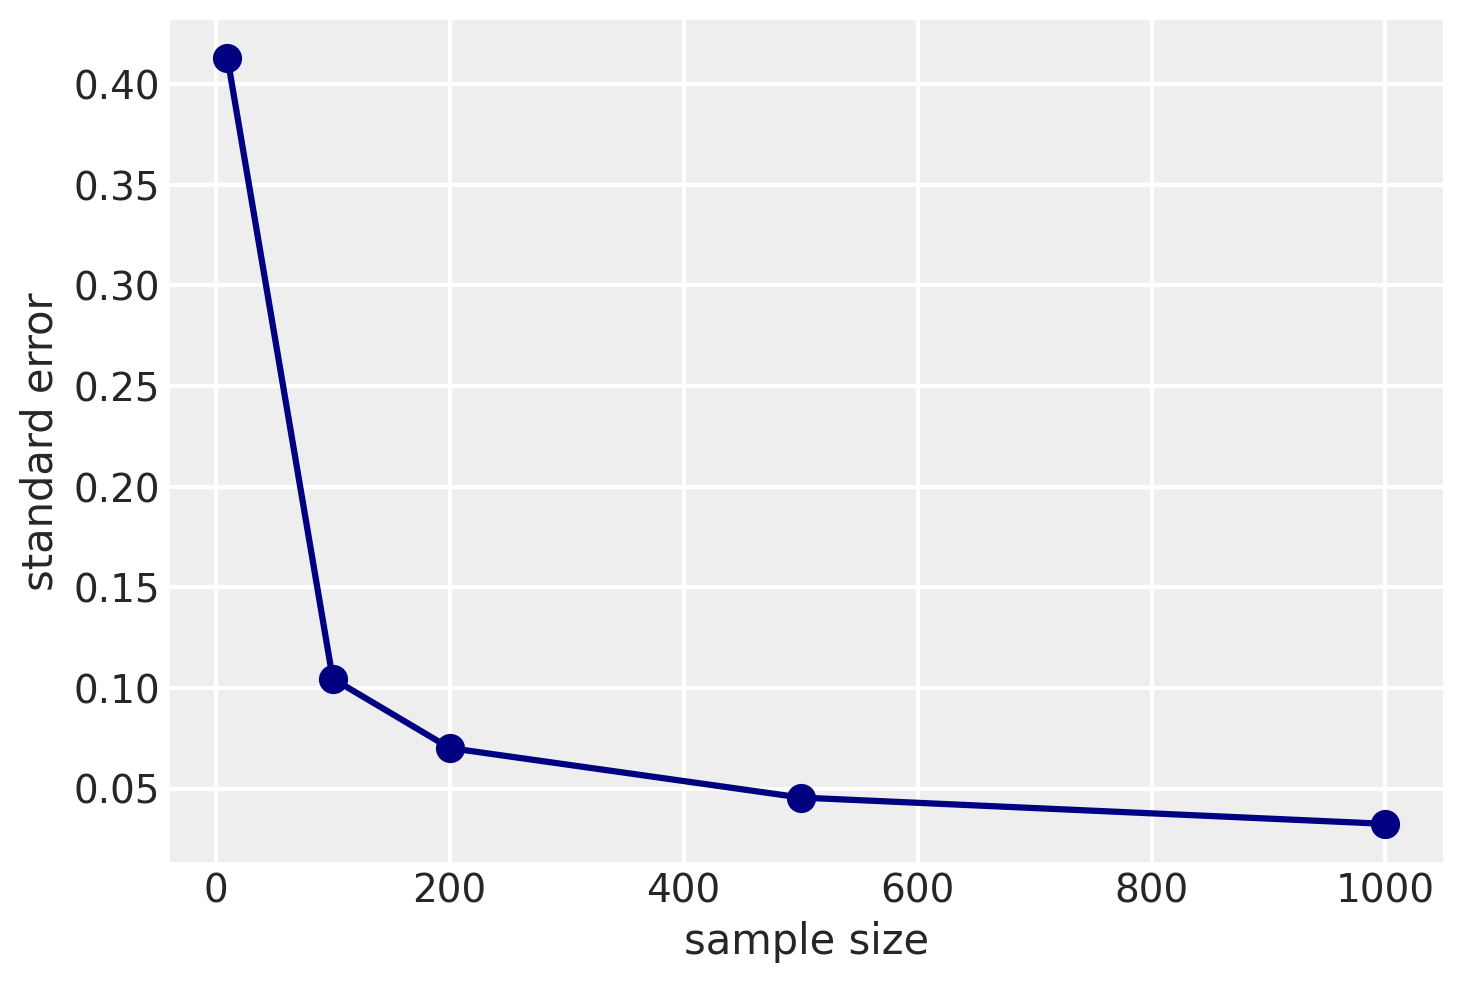

<IPython.core.display.Javascript object>

In [158]:
f, ax1 = plt.subplots()
for i, ss in enumerate(sample_size_list):
    ax1.scatter(ss, coef_list[i][1], label=str(ss), color='navy')
ax1.plot(sample_size_list, np.array(coef_list)[:, 1], color='navy')
ax1.set(xlabel='sample size', ylabel='standard error')

In [145]:
coef_list

[(1.4738356747569061, 0.4130603102642782),
 (1.1425773407005966, 0.10459929433531728),
 (0.9693379977060048, 0.07013674418669784),
 (0.9581939304346598, 0.045539195254065586),
 (0.9801280818471241, 0.03245700083272577)]

<IPython.core.display.Javascript object>

In [36]:
# start with x coming from random draws of a normal distribution around 0
X1 = stats.norm.rvs(0, 1, size=100)
# make y come from random draws of a normal distribution around x
Y1 = stats.norm.rvs(X1, 1, size=100)
# make z come from random draws of a normal distribution around x
Z1 = np.random.normal(Y1, 1, size=100)
# Z = np.random.normal(0, 1, size=100)*Y + 

df_sim = pd.DataFrame(
    {"X":X1, "Y":Y1, "Z":Z1}
)

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


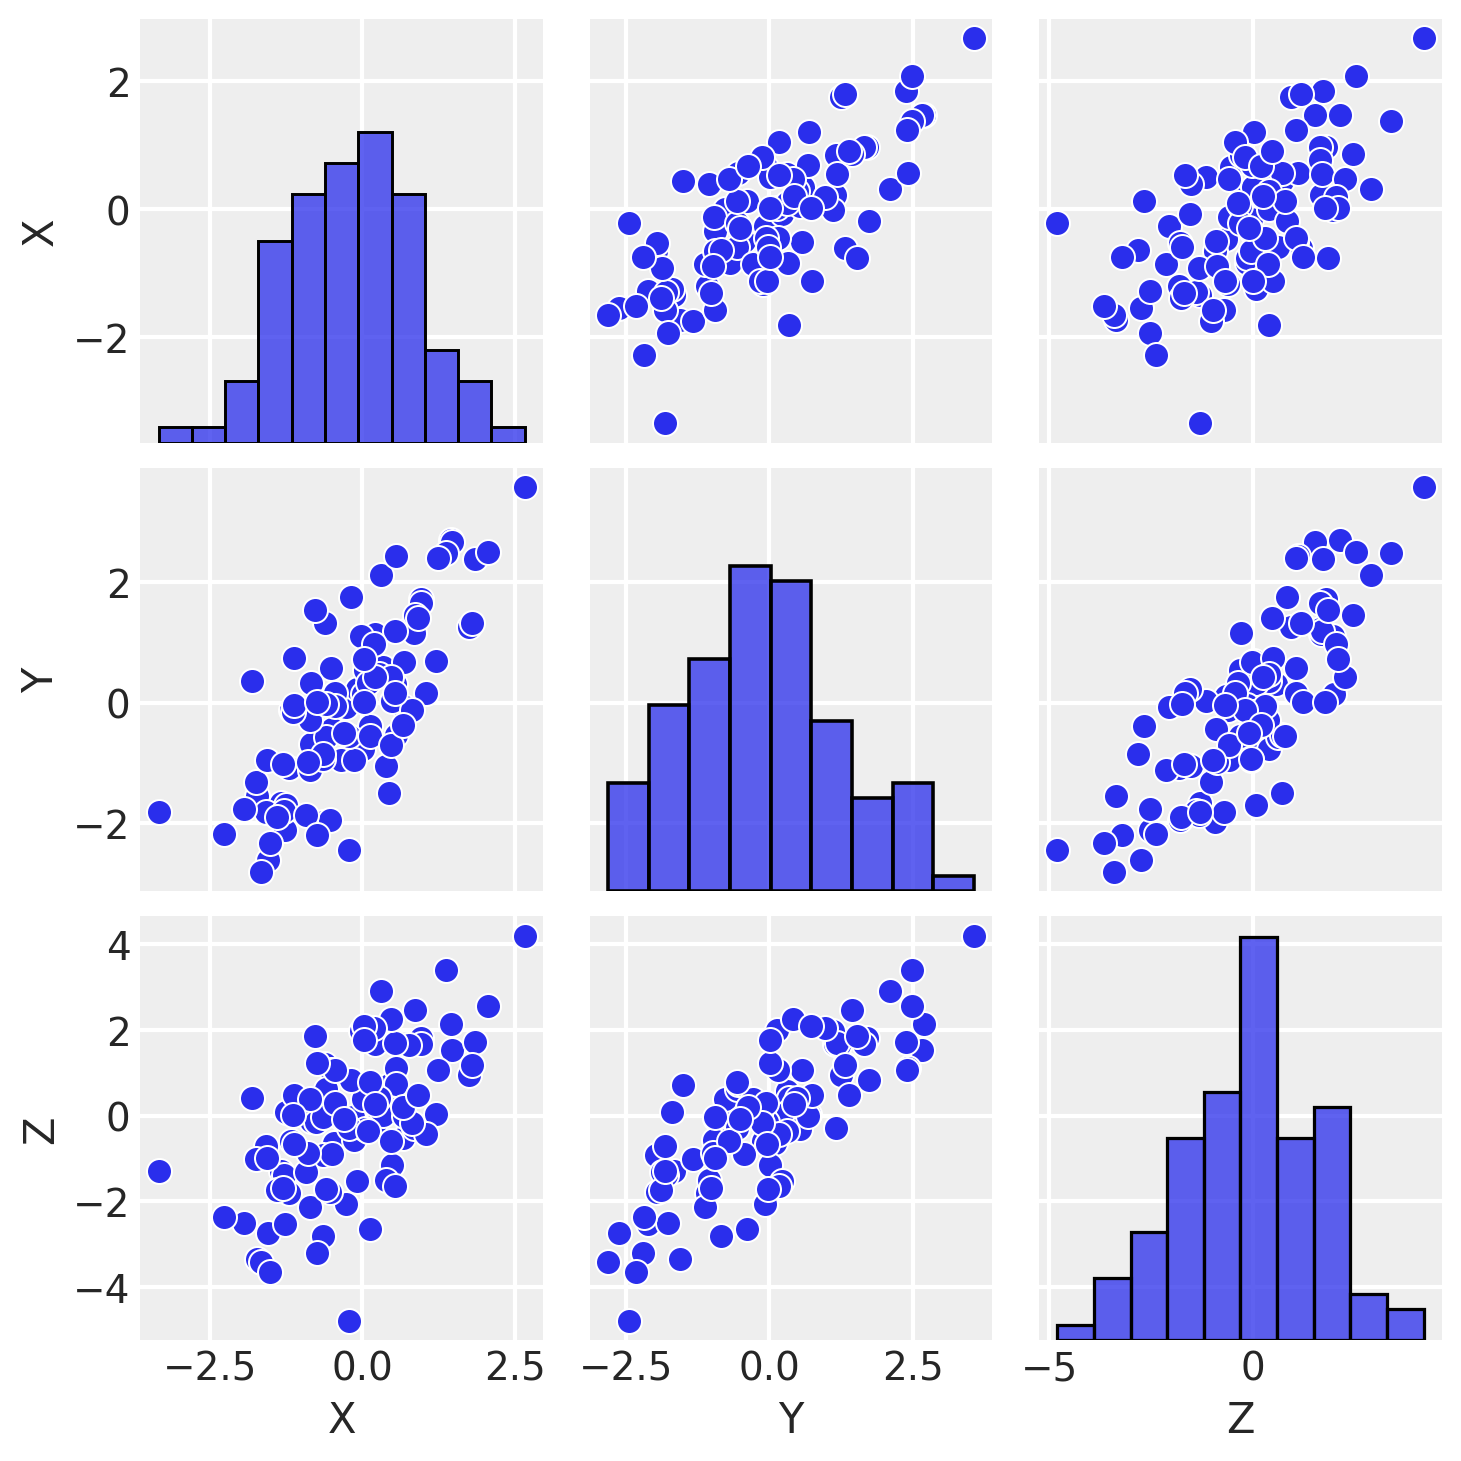

<IPython.core.display.Javascript object>

In [49]:
sns.pairplot(df_sim)

### Using `statsmodels`

In [45]:
import statsmodels.api as sm

<IPython.core.display.Javascript object>

In [47]:
res = sm.OLS(df_sim['Y'], df_sim['X']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.546
Method:                 Least Squares   F-statistic:                              121.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    6.85e-19
Time:                        16:25:34   Log-Likelihood:                         -133.42
No. Observations:                 100   AIC:                                      268.8
Df Residuals:                      99   BIC:                                      271.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.9658      0.088     11.013      0.000       0.792       1.140
==============================================================================
Omnibus:                        0.067   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.967   Jarque-Bera (JB):                0.207
Skew:                           0.044   Prob(JB):                        0.902
Kurtosis:                       2.796   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [48]:
res = sm.OLS(df_sim['Y'], df_sim[['X', 'Z']]).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.755
Model:                            OLS   Adj. R-squared (uncentered):              0.750
Method:                 Least Squares   F-statistic:                              150.9
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    1.20e-30
Time:                        16:26:00   Log-Likelihood:                         -103.11
No. Observations:                 100   AIC:                                      210.2
Df Residuals:                      98   BIC:                                      215.4
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.5155      0.082      6.289      0.000       0.353       0.678
Z              0.4702      0.052      9.038      0.000       0.367       0.573
==============================================================================
Omnibus:                        0.927   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.814
Skew:                          -0.219   Prob(JB):                        0.666
Kurtosis:                       2.943   Cond. No.                         2.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## Using `pymc`

In [50]:
df_sim.head()

,X,Y,Z
0,0.198388,0.521408,-0.246524
1,1.459678,2.691161,2.144239
2,0.542236,0.309511,0.578994
3,-0.472632,0.101527,-0.640011
4,-1.727338,-1.557110,-3.349159


<IPython.core.display.Javascript object>

In [53]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X']

    # likelihood
    y = pm.Normal("h1", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

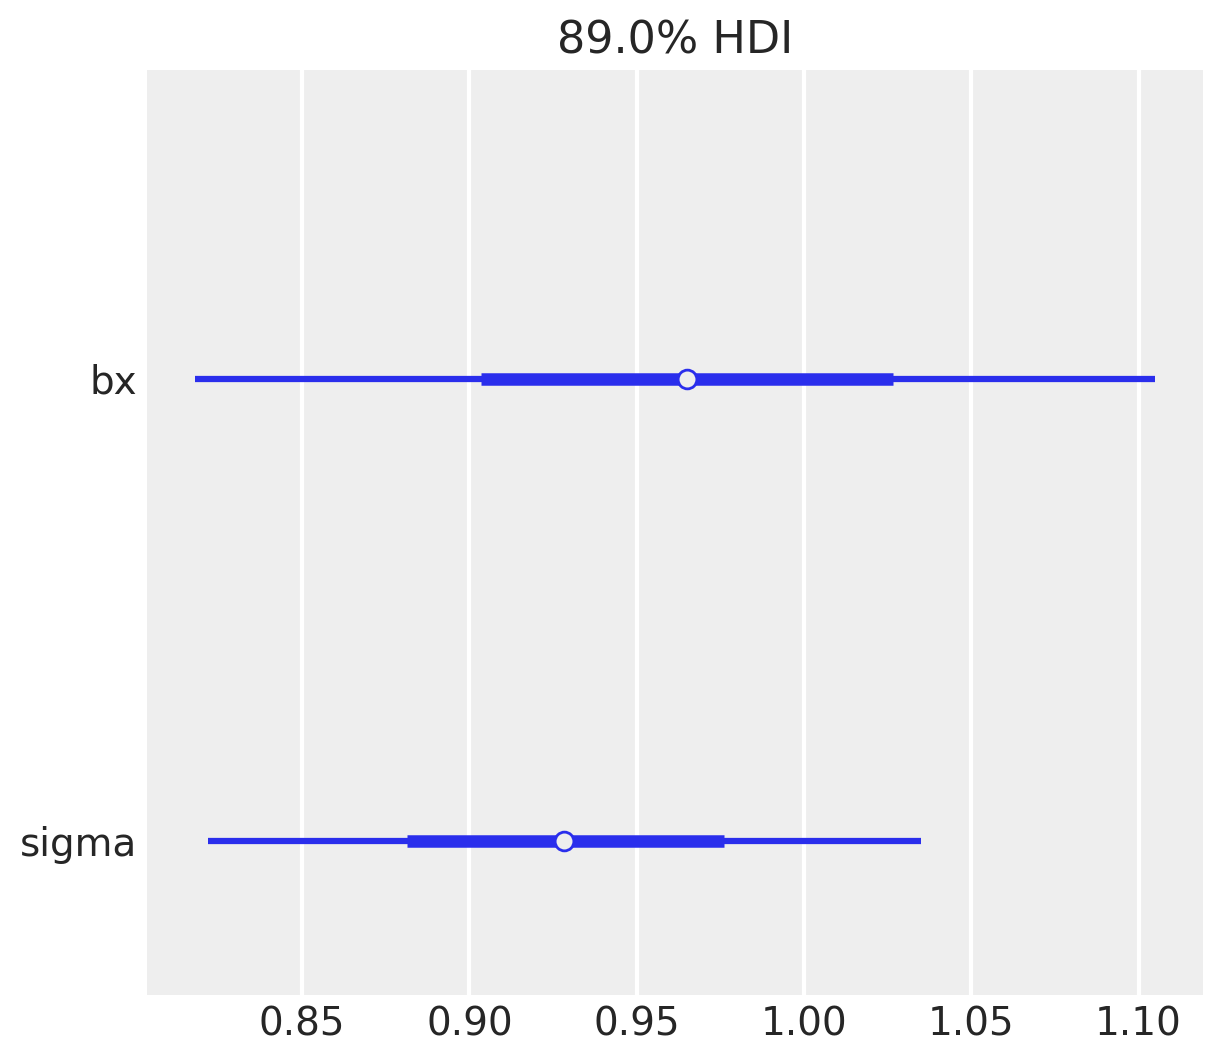

<IPython.core.display.Javascript object>

In [54]:
az.plot_forest(trace_m15m4a, combined=True)

In [56]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X'] + bz*df_sim['Z']

    # likelihood
    y = pm.Normal("h1", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

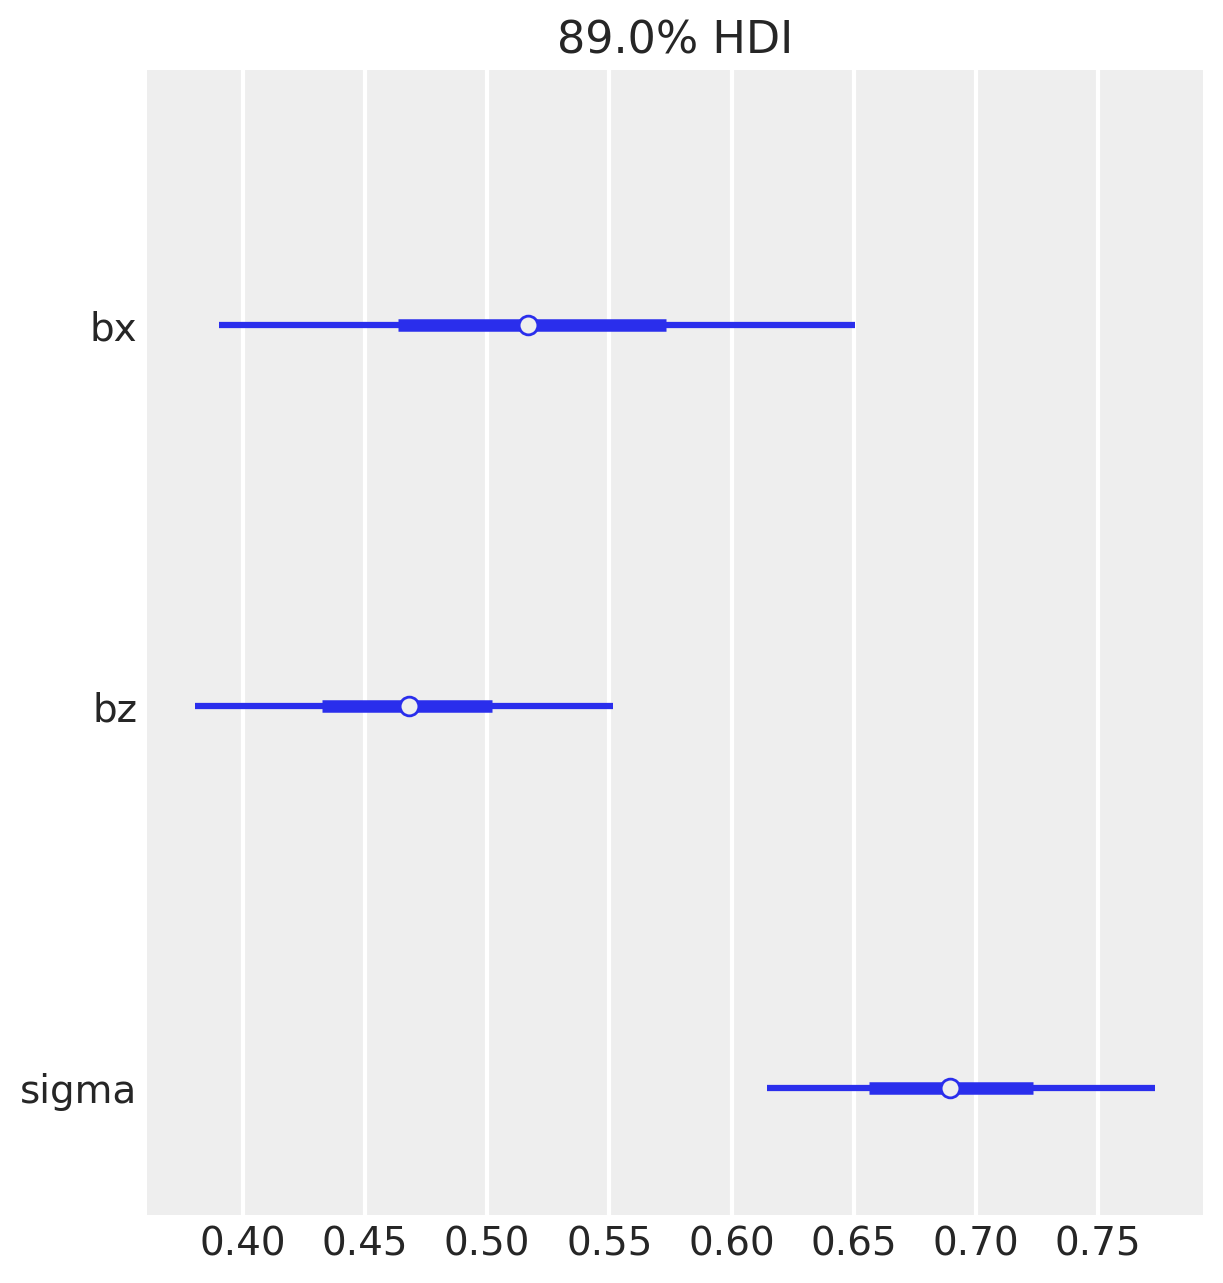

<IPython.core.display.Javascript object>

In [57]:
az.plot_forest(trace_m15m4b, combined=True)

In [ ]:
stats.linregress(X1, Y1)

## Change coefficient of sim

In [108]:
N_samples = 1000

# start with x coming from random draws of a normal distribution around 0
X1 = stats.norm.rvs(0, 1, size=N_samples)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
#Y1 = bX_sim * stats.norm.rvs(X1, 1, size=N_samples)
Y1 = stats.norm.rvs(bX_sim * X1, 1, size=N_samples)
# Y1 = bX_sim*X1
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z1 = bY_sim * np.random.normal(Y1, 1, size=N_samples)
# Z = np.random.normal(0, 1, size=100)*Y + 

df_sim = pd.DataFrame(
    {"X":X1, "Y":Y1, "Z":Z1}
)

<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='Density'>

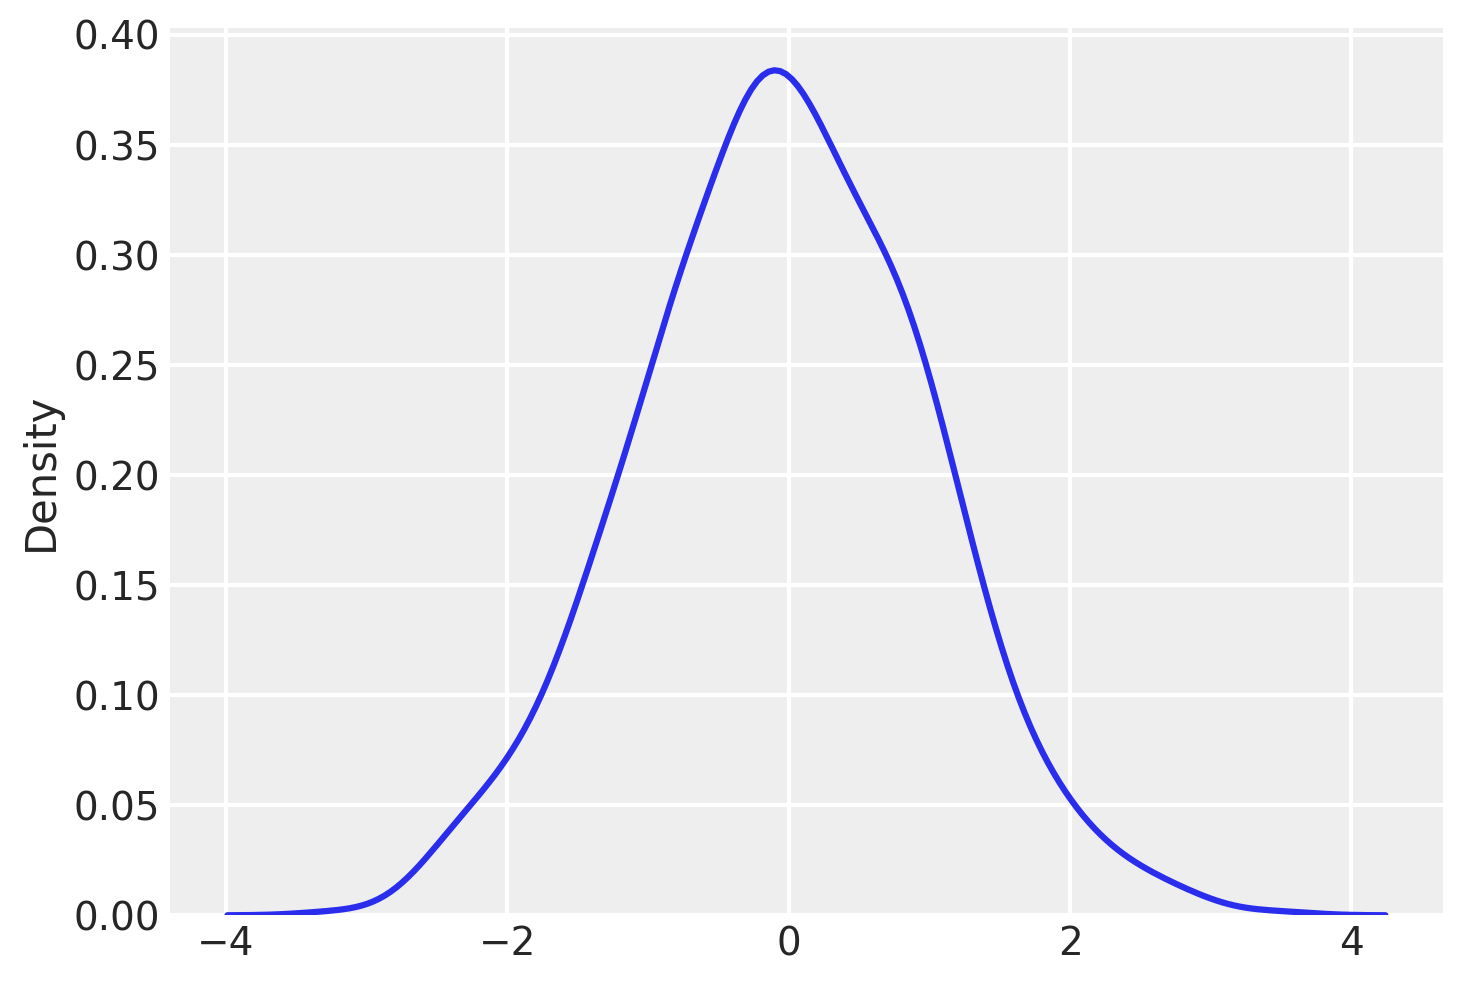

<IPython.core.display.Javascript object>

In [109]:
sns.kdeplot(X1)

In [103]:
(bX_sim * X1).mean()

0.097787496274374

<IPython.core.display.Javascript object>

In [101]:
X1.mean(), Y1.mean()

(0.13969642324910575, 0.15530444695953843)

<IPython.core.display.Javascript object>

In [100]:
0.7*0.3

0.21

<IPython.core.display.Javascript object>

In [110]:
sm.OLS(df_sim['Y'], df_sim[['X']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.354
Model:                            OLS   Adj. R-squared (uncentered):              0.354
Method:                 Least Squares   F-statistic:                              548.4
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    5.08e-97
Time:                        18:07:42   Log-Likelihood:                         -1415.7
No. Observations:                1000   AIC:                                      2833.
Df Residuals:                     999   BIC:                                      2838.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.7177      0.031     23.417      0.000       0.658       0.778
==============================================================================
Omnibus:                        6.535   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                8.102
Skew:                           0.070   Prob(JB):                       0.0174
Kurtosis:                       3.418   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [111]:
sm.OLS(df_sim['Y'], df_sim[['X', 'Z']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.672
Model:                            OLS   Adj. R-squared (uncentered):              0.671
Method:                 Least Squares   F-statistic:                              1023.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   2.32e-242
Time:                        18:08:07   Log-Likelihood:                         -1076.9
No. Observations:                1000   AIC:                                      2158.
Df Residuals:                     998   BIC:                                      2168.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.3742      0.024     15.281      0.000       0.326       0.422
Z              1.6637      0.054     31.095      0.000       1.559       1.769
==============================================================================
Omnibus:                        2.397   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                2.265
Skew:                           0.090   Prob(JB):                        0.322
Kurtosis:                       3.148   Cond. No.                         2.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


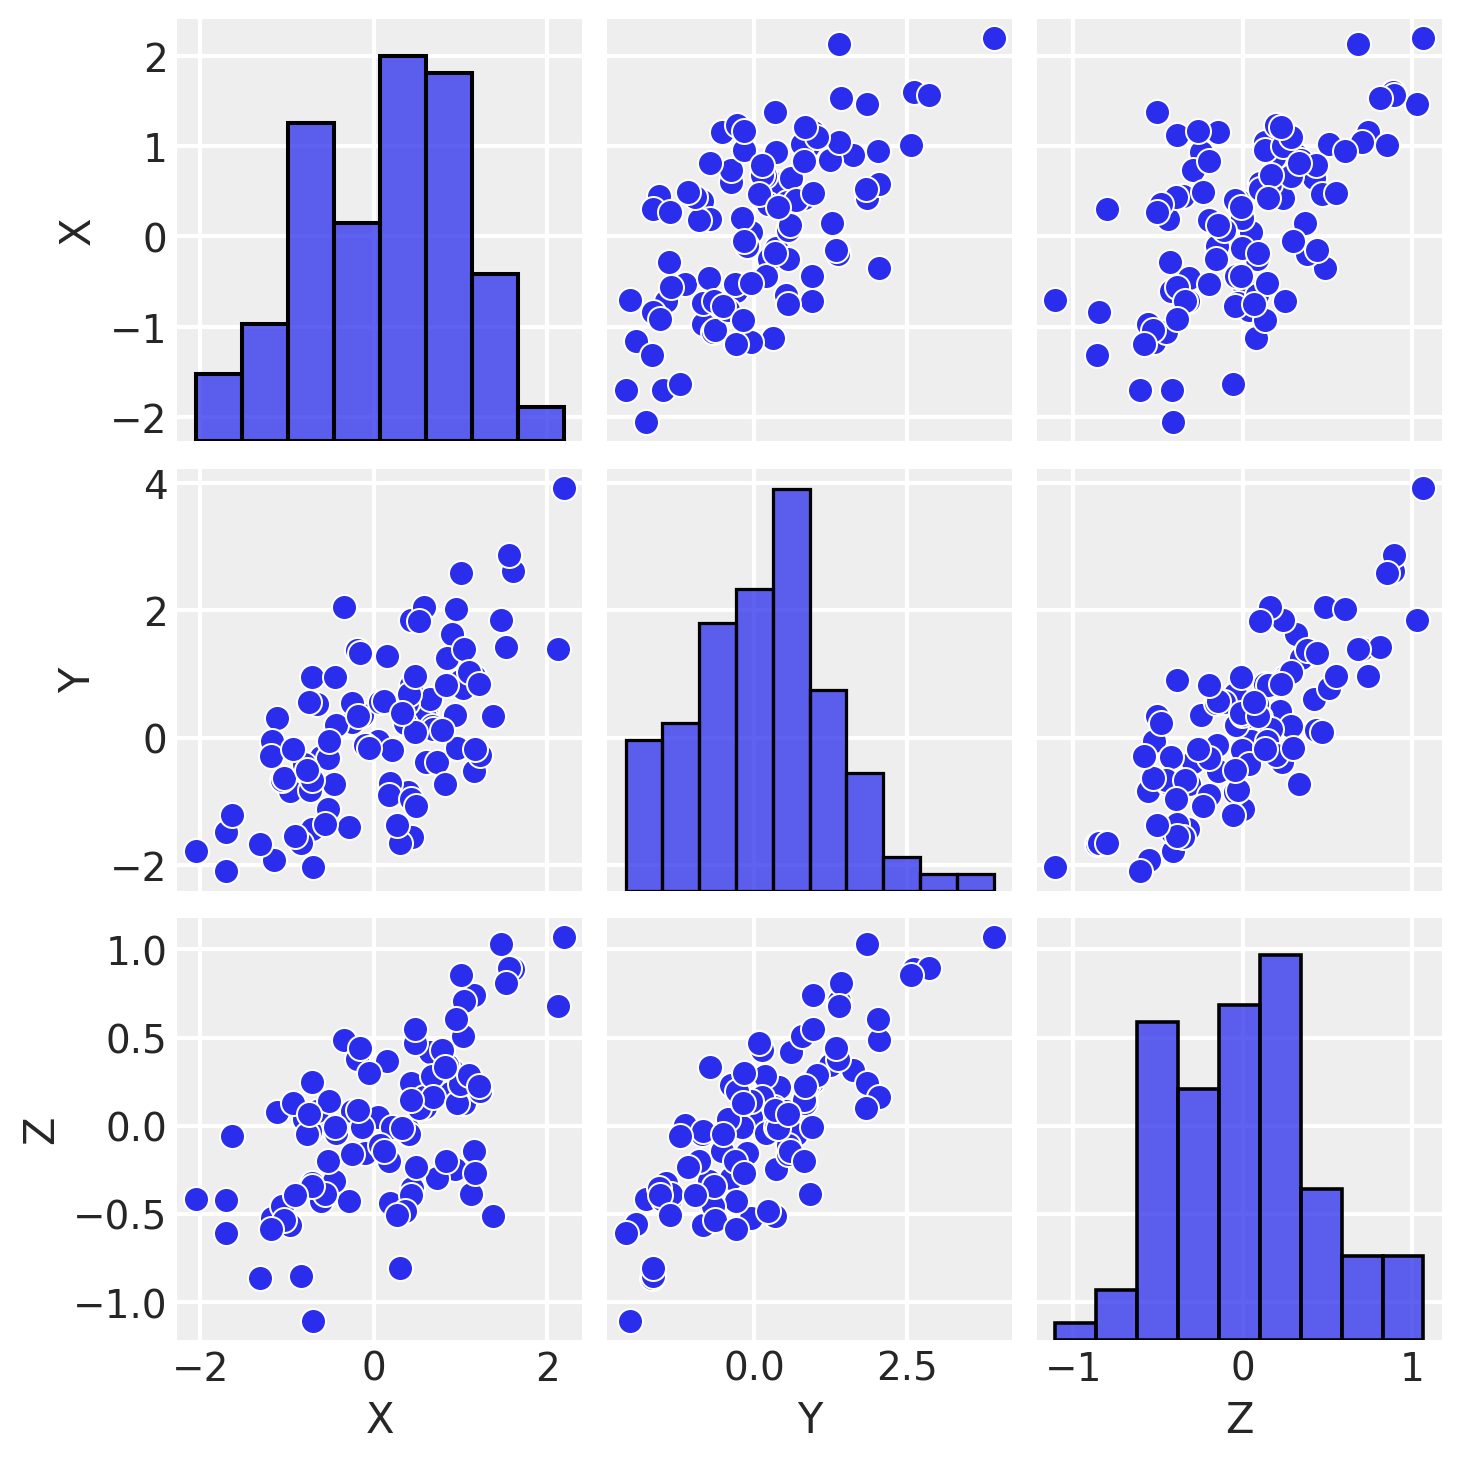

<IPython.core.display.Javascript object>

In [97]:
sns.pairplot(df_sim)

In [112]:
sm.OLS(df_sim['Y'], df_sim[['Z']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              1470.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   1.76e-198
Time:                        18:08:37   Log-Likelihood:                         -1182.1
No. Observations:                1000   AIC:                                      2366.
Df Residuals:                     999   BIC:                                      2371.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Z              2.0326      0.053     38.339      0.000       1.929       2.137
==============================================================================
Omnibus:                        3.821   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.148   Jarque-Bera (JB):                3.678
Skew:                           0.132   Prob(JB):                        0.159
Kurtosis:                       3.136   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

## Change the outcome

In [113]:
sm.OLS(df_sim['Z'], df_sim[['X', 'Y']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              734.5
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   7.45e-197
Time:                        18:09:26   Log-Likelihood:                         -213.32
No. Observations:                1000   AIC:                                      430.6
Df Residuals:                     998   BIC:                                      440.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.0058      0.011     -0.506      0.613      -0.028       0.017
Y              0.2958      0.010     31.095      0.000       0.277       0.314
==============================================================================
Omnibus:                        2.486   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                2.438
Skew:                          -0.121   Prob(JB):                        0.296
Kurtosis:                       3.011   Cond. No.                         2.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [117]:
sm.OLS(df_sim['Z'], df_sim[['Y']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.595
Method:                 Least Squares   F-statistic:                              1470.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                   1.76e-198
Time:                        18:10:13   Log-Likelihood:                         -213.45
No. Observations:                1000   AIC:                                      428.9
Df Residuals:                     999   BIC:                                      433.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y              0.2929      0.008     38.339      0.000       0.278       0.308
==============================================================================
Omnibus:                        2.608   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.559
Skew:                          -0.124   Prob(JB):                        0.278
Kurtosis:                       3.012   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [118]:
sm.OLS(df_sim['Z'], df_sim[['X']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.204
Model:                            OLS   Adj. R-squared (uncentered):              0.203
Method:                 Least Squares   F-statistic:                              255.3
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                    2.38e-51
Time:                        18:10:30   Log-Likelihood:                         -552.03
No. Observations:                1000   AIC:                                      1106.
Df Residuals:                     999   BIC:                                      1111.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.2065      0.013     15.978      0.000       0.181       0.232
==============================================================================
Omnibus:                        1.707   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.607
Skew:                          -0.095   Prob(JB):                        0.448
Kurtosis:                       3.051   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [119]:
sm.OLS(df_sim['Z'], df_sim[['X']]).fit().params

X    0.206468
dtype: float64

<IPython.core.display.Javascript object>

In [120]:
sm.OLS(df_sim['Z'], df_sim[['X', 'Y']]).fit().params

X   -0.005799
Y    0.295766
dtype: float64

<IPython.core.display.Javascript object>

## Colliders pointing to Z

In [121]:
N_samples = 1000

# start with x coming from random draws of a normal distribution around 0
X1 = stats.norm.rvs(0, 1, size=N_samples)
bX_sim = 0.7

# make y come from random draws of a normal distribution around x
#Y1 = bX_sim * stats.norm.rvs(X1, 1, size=N_samples)
Y1 = stats.norm.rvs(1, 1, size=N_samples)
# Y1 = bX_sim*X1
bY_sim = 0.3

# make z come from random draws of a normal distribution around x
Z1 = bX_sim * np.random.normal(X1, 1, size=N_samples) + bY_sim * np.random.normal(Y1, 1, size=N_samples) 
# Z = np.random.normal(0, 1, size=100)*Y + 

df_sim = pd.DataFrame(
    {"X":X1, "Y":Y1, "Z":Z1}
)

<IPython.core.display.Javascript object>

In [122]:
sm.OLS(df_sim['Z'], df_sim[['X', 'Y']]).fit().params

X    0.674042
Y    0.298147
dtype: float64

<IPython.core.display.Javascript object>

In [123]:
sm.OLS(df_sim['Z'], df_sim[['X']]).fit().params

X    0.667398
dtype: float64

<IPython.core.display.Javascript object>

In [124]:
sm.OLS(df_sim['Z'], df_sim[['Y']]).fit().params

Y    0.290141
dtype: float64

<IPython.core.display.Javascript object>

In [125]:
sm.OLS(df_sim['X'], df_sim[['Y']]).fit().params

Y   -0.011876
dtype: float64

<IPython.core.display.Javascript object>

In [126]:
sm.OLS(df_sim['X'], df_sim[['Y', 'Z']]).fit().params

Y   -0.210500
Z    0.684574
dtype: float64

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


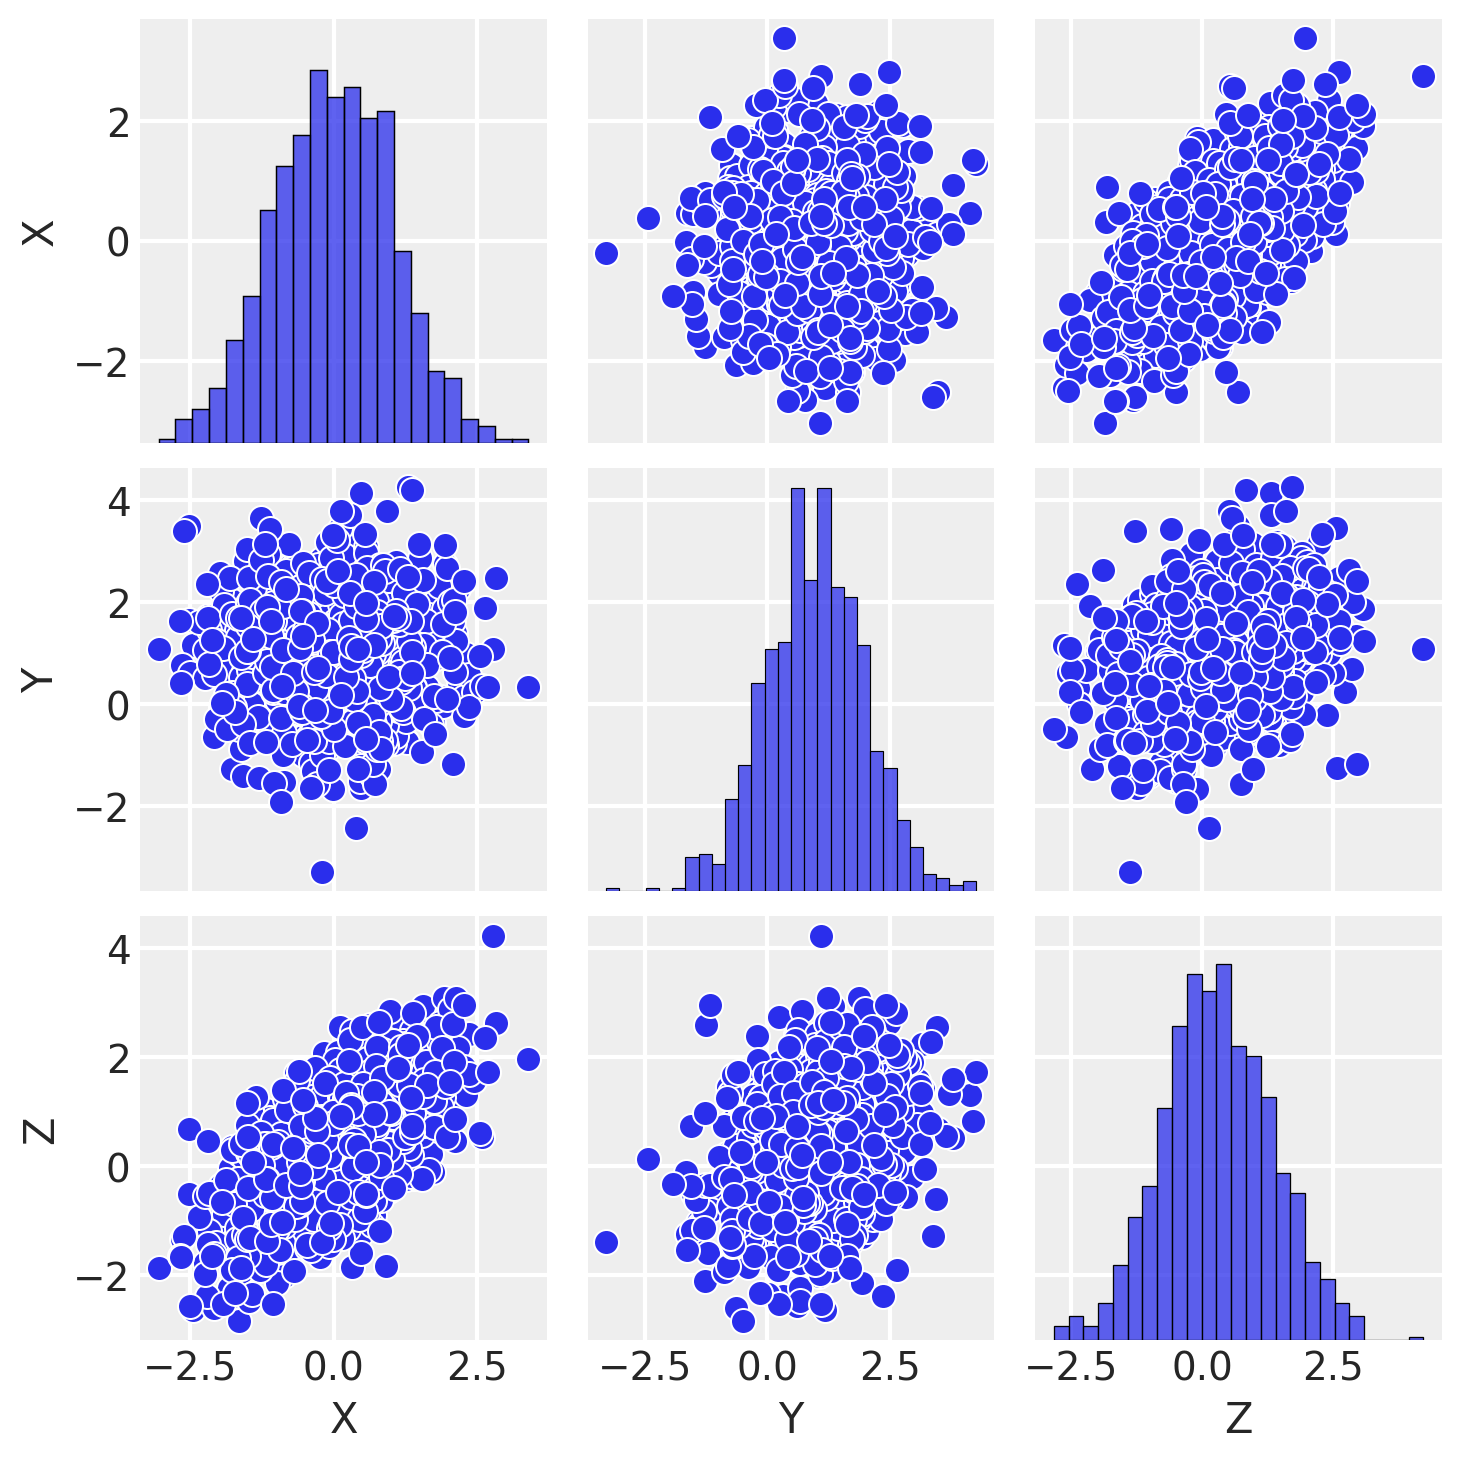

<IPython.core.display.Javascript object>

In [127]:
sns.pairplot(df_sim)

In [85]:
with pm.Model() as m15m4a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4a = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [87]:
with pm.Model() as m15m4b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X'] + bz*df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4b = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [89]:
with pm.Model() as m15m4c:
    
    # priors
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bz*df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # prior predictive checks
    prior_checks_m15m4c = pm.sample_prior_predictive(samples=10**5)

    # sample
    trace_m15m4c = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [92]:
az.summary(trace_m15m4a)
# az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
# az.plot_forest(trace_m15m4c, combined=True, ax=ax3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bx,0.620,0.073,0.507,0.736,0.001,0.001,3439.0,3439.0,3449.0,2680.0,1.0
sigma,0.721,0.052,0.641,0.802,0.001,0.001,3362.0,3287.0,3491.0,2438.0,1.0


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

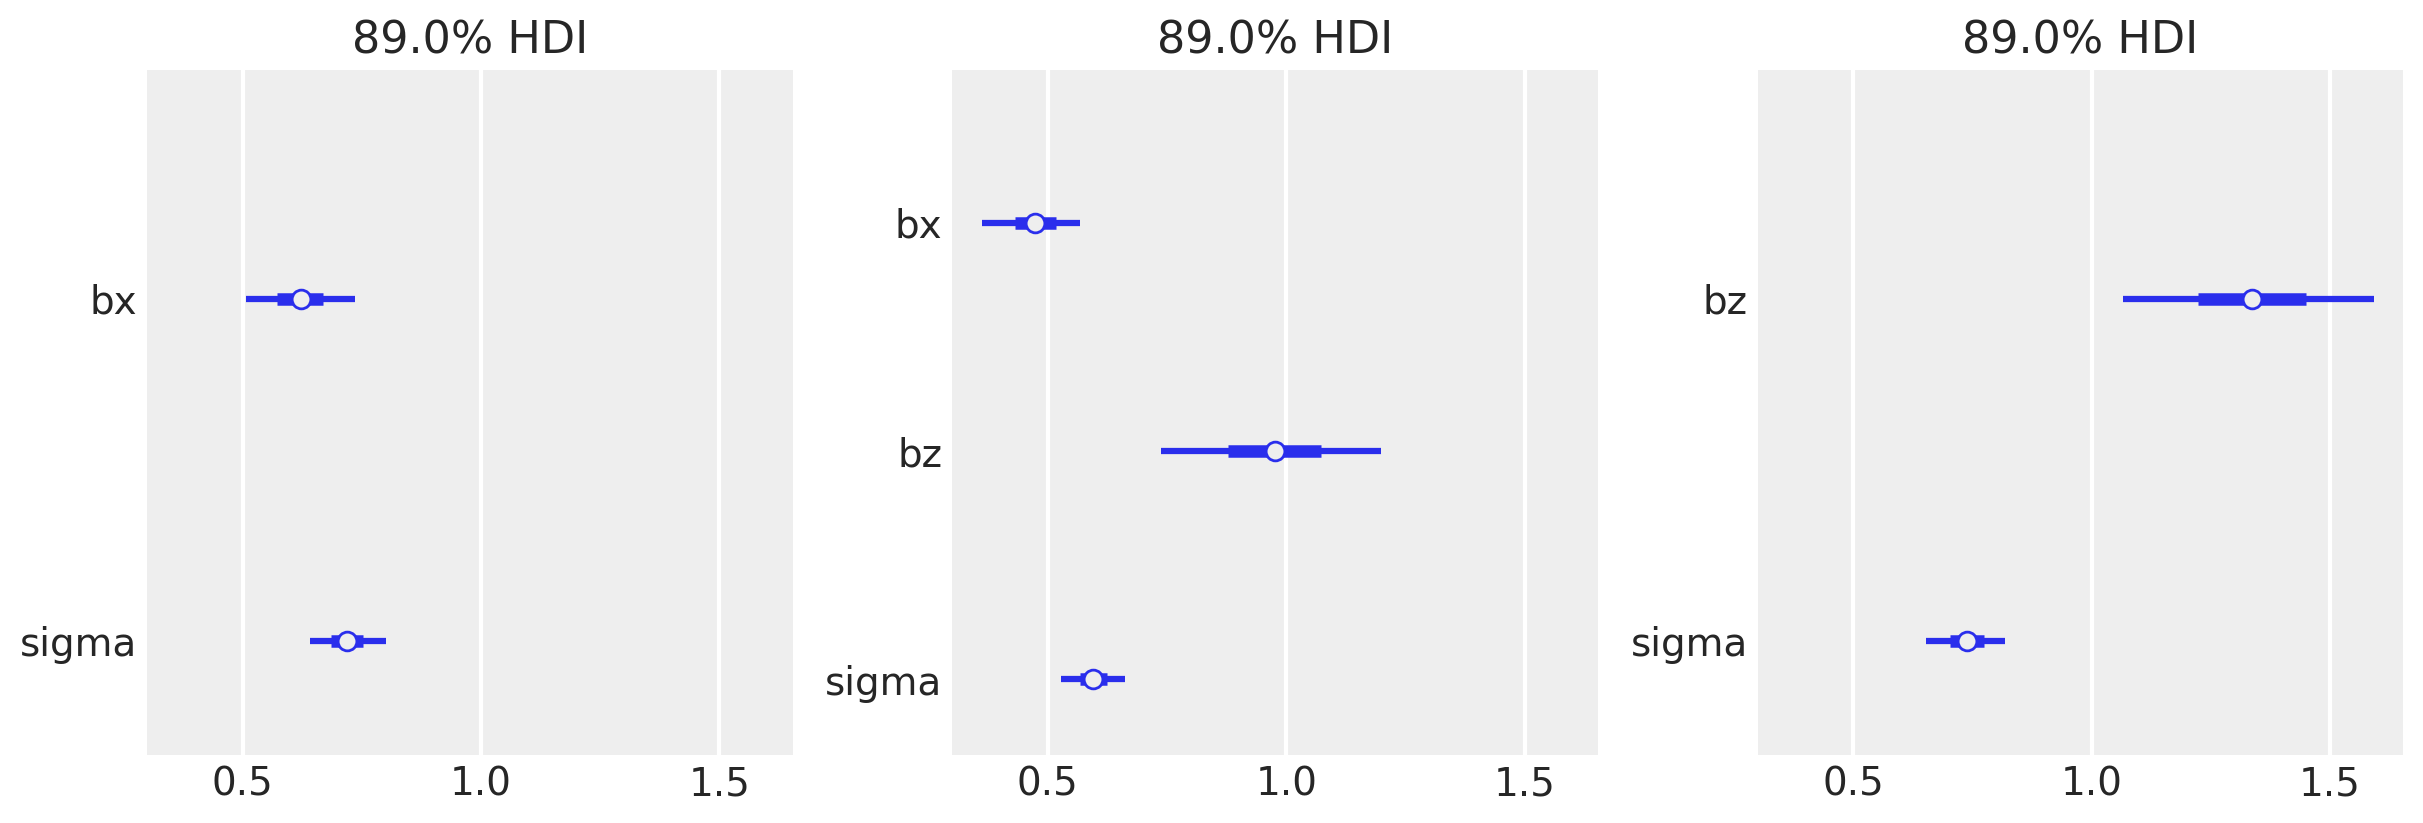

<IPython.core.display.Javascript object>

In [90]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
az.plot_forest(trace_m15m4a, combined=True, ax=ax1)
az.plot_forest(trace_m15m4b, combined=True, ax=ax2)
az.plot_forest(trace_m15m4c, combined=True, ax=ax3)

## Post with mediator, fork, collider

- have arrows pointing in different directions (X > Y > Z; X > Y < Z)
- have outcomes vary, in each condition (predict Y, predict Z, etc.)
- show how all can be correlated
- impact of sample size

## Post with binomial versus normal distributions
- variable is continuous versus categorical

## Impact of different kinds of simulations/magnitudes

Scott's R code

```
n <- 10000
x <- rnorm(n)
y <- 0.5*x+rnorm(n)
z <- 0.4*y+rnorm(n)

d <- data.frame(x,y,z)
lm(y~z+x)
lm(y~x)
```

In [71]:
n = 10**5
x = stats.norm.rvs(size=n)
y = 0.5*x + stats.norm.rvs(n)
z = 0.4*y + stats.norm.rvs(n)

df_sim2 = pd.DataFrame({"X":x, "Y":y, "Z":z})


<IPython.core.display.Javascript object>

In [72]:
sm.OLS(df_sim2['Y'], df_sim2[['X']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                            0.03933
Date:                Thu, 16 Dec 2021   Prob (F-statistic):                       0.843
Time:                        17:04:54   Log-Likelihood:                     -1.2932e+06
No. Observations:              100000   AIC:                                  2.586e+06
Df Residuals:                   99999   BIC:                                  2.586e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X            -62.7574    316.467     -0.198      0.843    -683.028     557.513
==============================================================================
Omnibus:                        0.823   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.663   Jarque-Bera (JB):                0.826
Skew:                          -0.007   Prob(JB):                        0.662
Kurtosis:                       2.997   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [73]:
sm.OLS(df_sim2['Y'], df_sim2[['X', 'Z']]).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.964e+24
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:05:10   Log-Likelihood:             2.2187e+06
No. Observations:              100000   AIC:                        -4.437e+06
Df Residuals:                   99998   BIC:                        -4.437e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.3571   1.77e-13   2.02e+12      0.000       0.357       0.357
Z              0.7143   1.26e-18   5.65e+17      0.000       0.714       0.714
==============================================================================
Omnibus:                      777.903   Durbin-Watson:                   0.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              536.605
Skew:                          -0.047   Prob(JB):                    3.00e-117
Kurtosis:                       2.654   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

In [77]:
with pm.Model() as m15m4_2a:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # sample
    trace_m15m4_2a = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

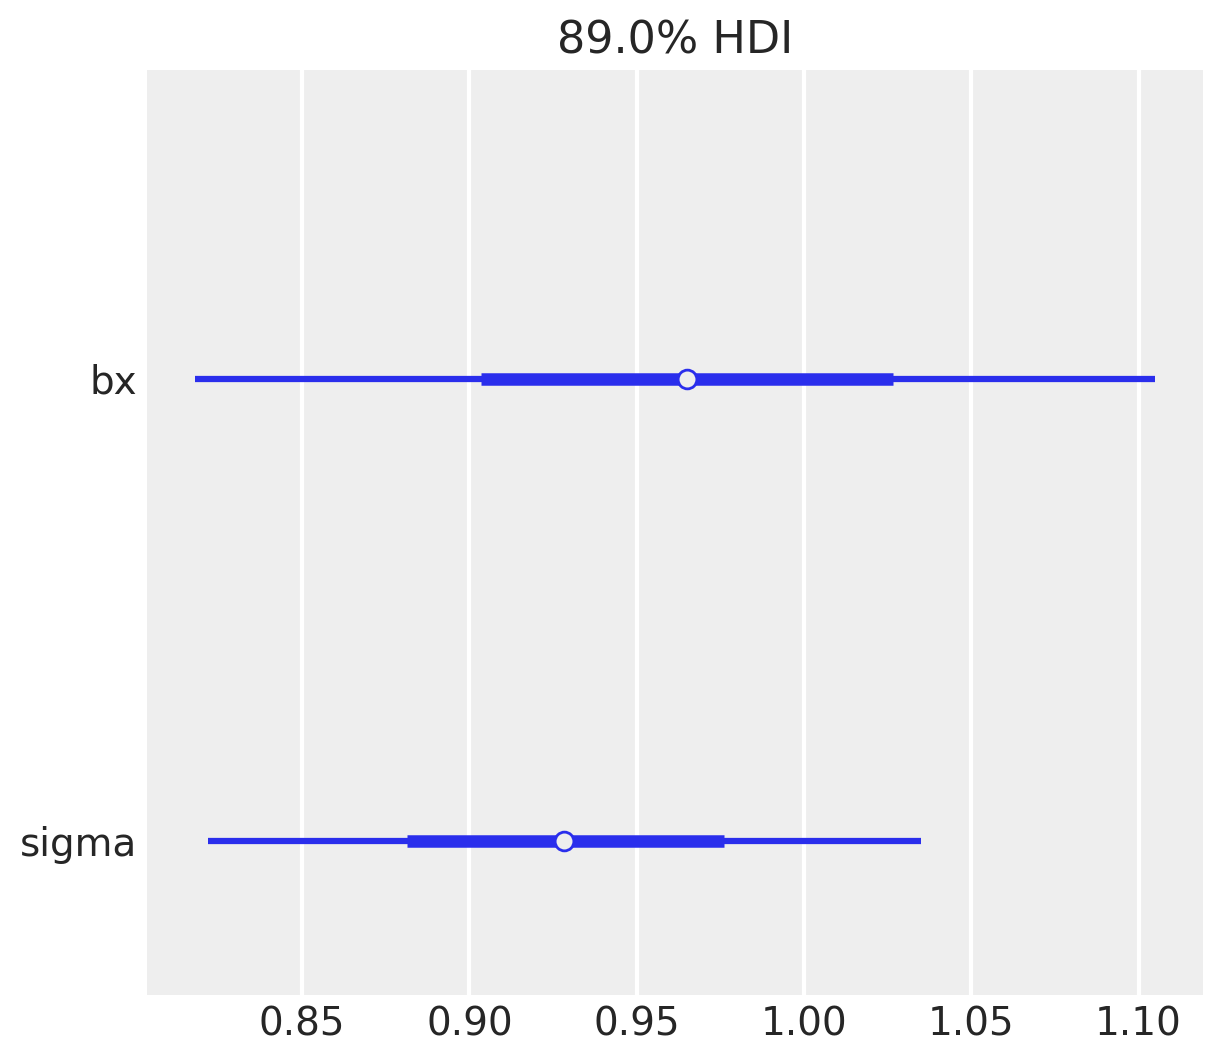

<IPython.core.display.Javascript object>

In [79]:
with pm.Model() as m15m4_2b:
    
    # priors
    bx = pm.Normal("bx", 0, 2)
    bz = pm.Normal("bz", 0, 2)
    sigma = pm.HalfNormal("sigma", 1)

    # linear model
    mu = bx*df_sim['X'] + bz*df_sim['Z']

    # likelihood
    y = pm.Normal("y", mu, sigma, observed=df_sim['Y'])

    # sample
    trace_m15m4_2b = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

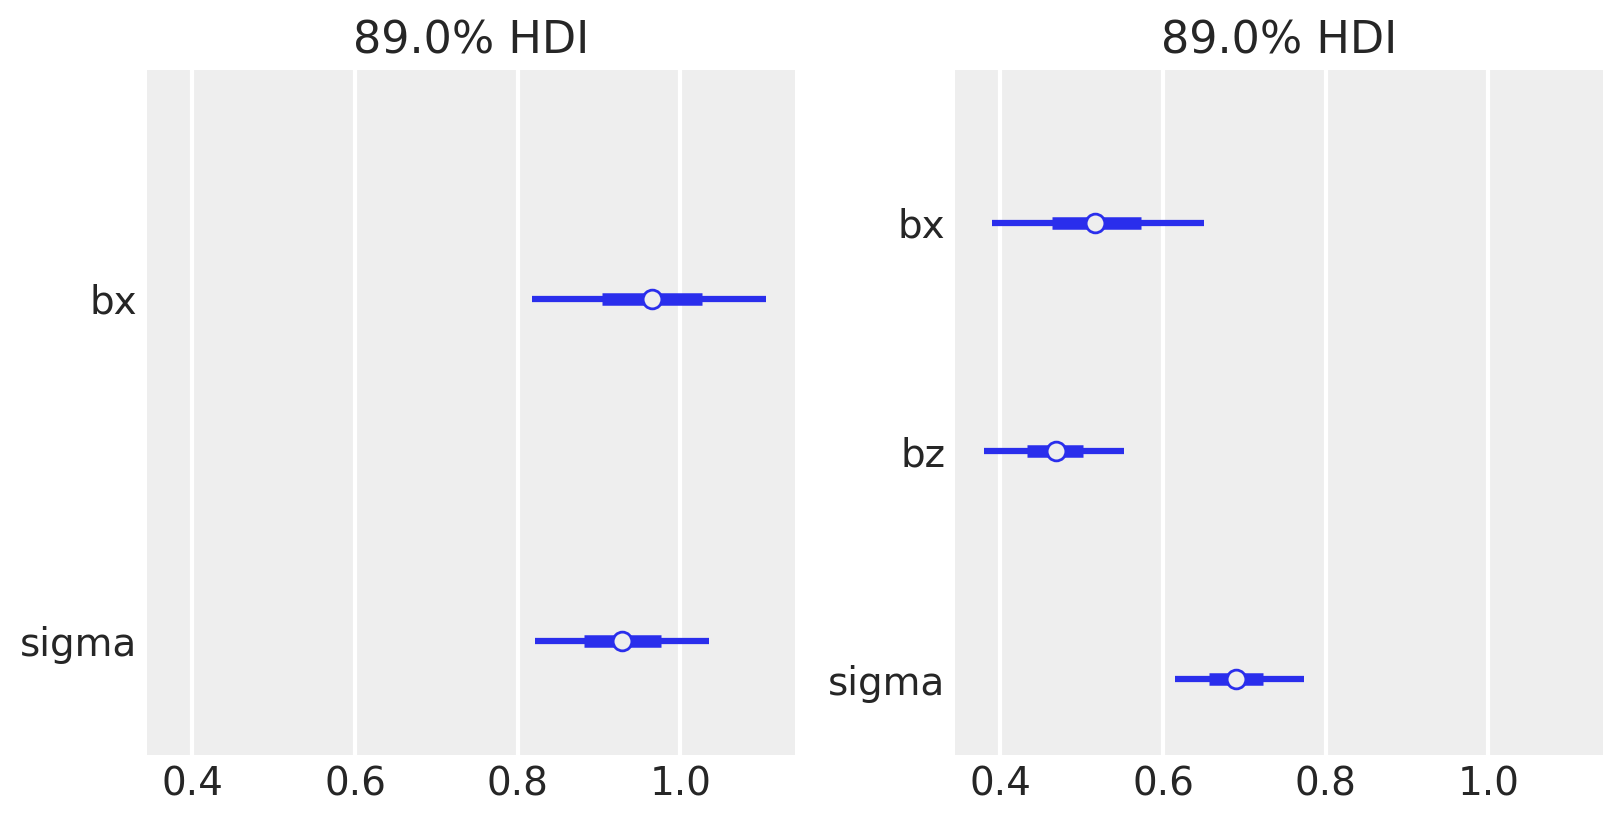

<IPython.core.display.Javascript object>

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
az.plot_forest(trace_m15m4_2a, combined=True, ax=ax1)
az.plot_forest(trace_m15m4_2b, combined=True, ax=ax2)

In [22]:
X = np.random.normal(0, 1, size=100)
Y = np.random.normal(0, 1, size=100)*X + 0.25
Z = np.random.normal(0, 1, size=100)*Y + 1

df = pd.DataFrame(np.array([X,Y,Z]).reshape(100,3))
df.columns = ['X', 'Y', 'Z']

<IPython.core.display.Javascript object>

In [ ]:
az.plot_forest(trace_m15m4b, combined=True)

In [52]:
df.iloc[:, 1:3].corr()

,Y,Z
Y,1.000000,0.284929
Z,0.284929,1.000000


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


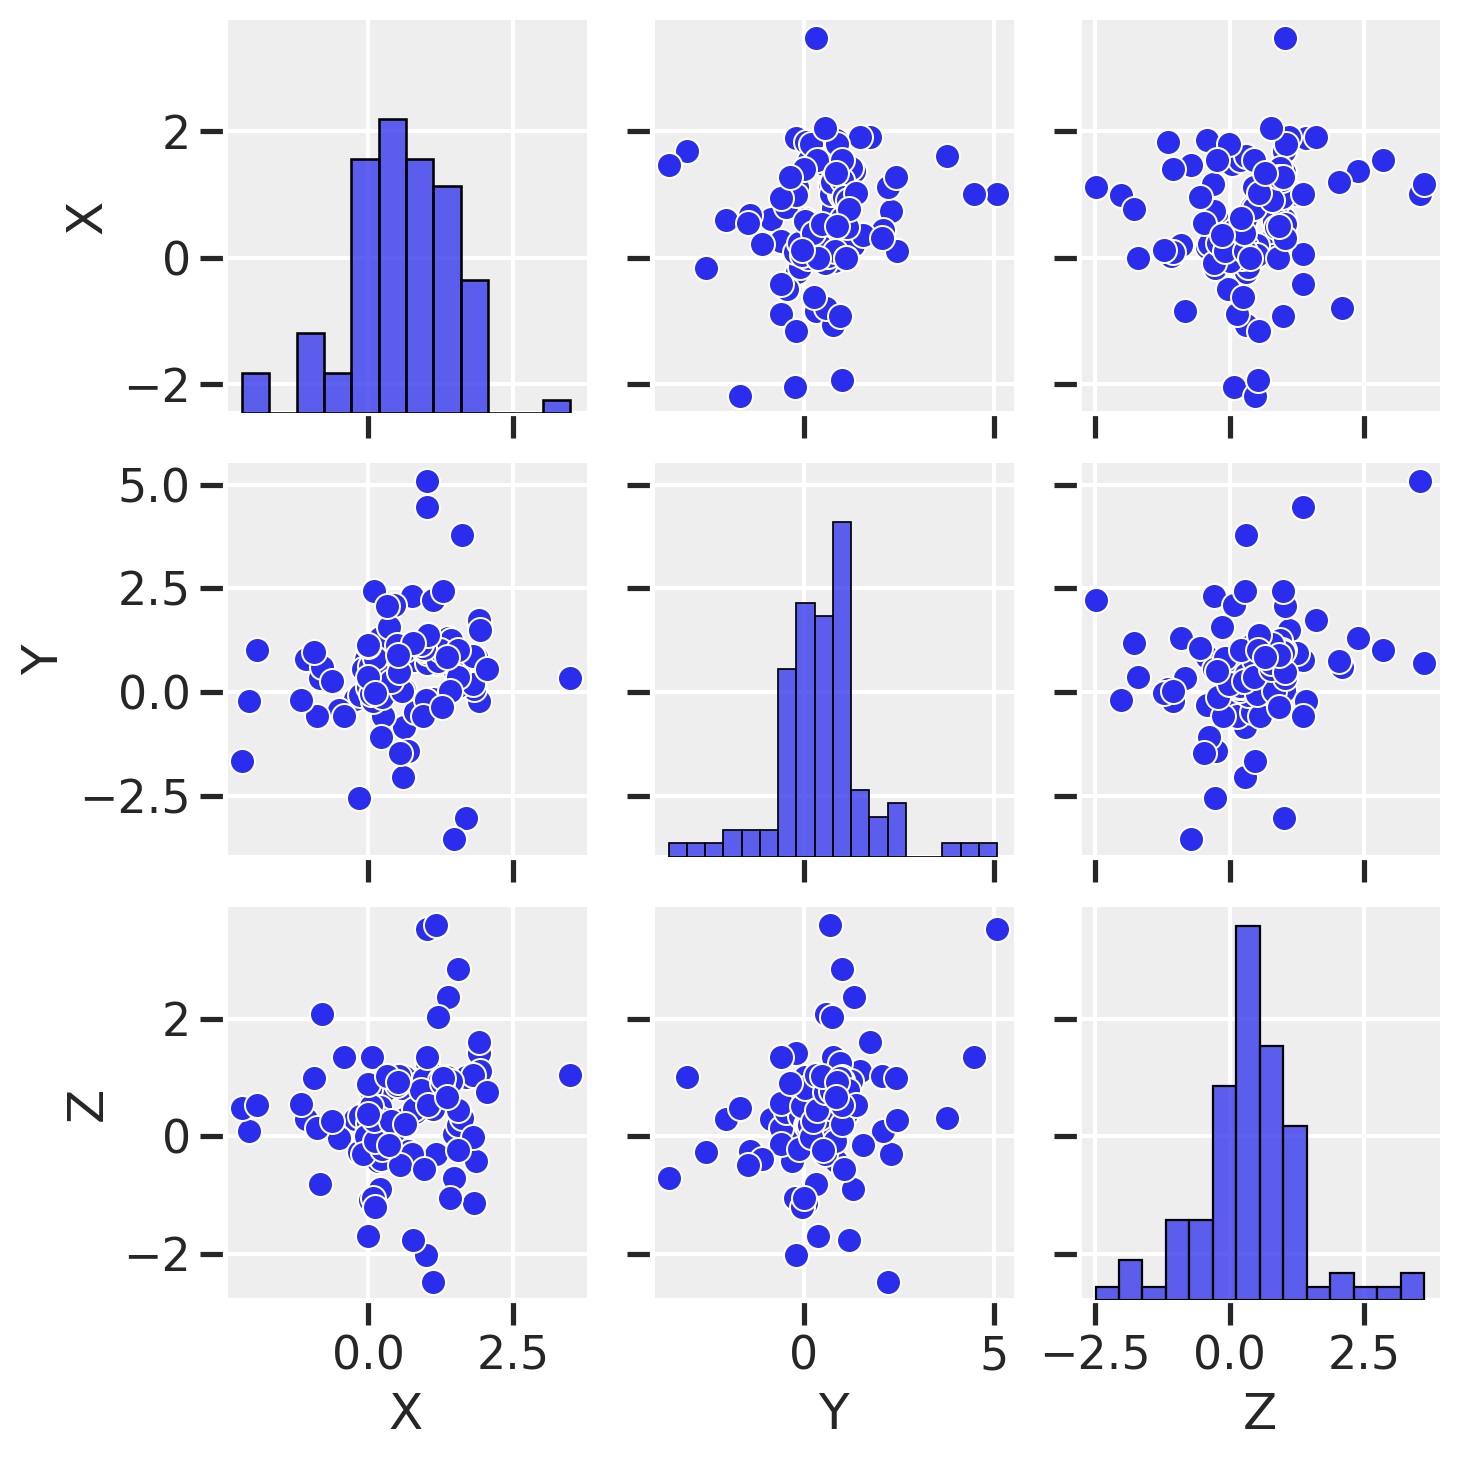

<IPython.core.display.Javascript object>

In [48]:
sns.pairplot(df)

In [ ]:
sns.

In [ ]:
with pm.Model() as m1:

    # prior
    a = pm.Normal()


    # likelihood?


    

### Simulation from McElreath's causal salad lecture

McElreath's [causal salad](https://github.com/rmcelreath/causal_salad_2021/blob/main/1_causal_salad.r) example.

In [ ]:
# 

## Back to Section 3.3

I still didn't understand above, so he explitly goes over simulation to simulate prediction here.

In [53]:
from scipy.stats import binom

<IPython.core.display.Javascript object>

Probability of observing 0, 1, 2 water for three tosses of the globe.

In [126]:
# dbinom( 0:2,size=2,prob=0.7)
# n = tosses of the globe
# k = list of desired observations (range(3)) is 0,1,2
stats.binom.pmf(k=[0,1,2], n=2, p=0.7)


array([0.09, 0.42, 0.49])

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [4]:
%watermark -n -u -v -iv -w

Last updated: Tue Dec 21 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
arviz      : 0.11.1
numpy      : 1.20.1
daft       : 0.1.0
pandas     : 1.2.1
matplotlib : 3.3.4
pymc3      : 3.11.0
json       : 2.0.9
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>